# Laboratorium 5: Segmentacja polipów — Architektura typu U-Net(Kvasir-SEG)

W tym ćwiczeniu chcemy nauczyć się budowania i trenowania modeli **segmentacji semantycznej** z wykorzystaniem architektury **U-Net** oraz frameworka **PyTorch Lightning** na zbiorze danych medycznych **Kvasir-SEG** (segmentacja polipów jelitowych w obrazach endoskopowych).

**Główne zagadnienia:**
- Implementacja `LightningDataModule`: podział train/val/test, augmentacje spójne dla obrazu i maski.
- Budowa architektury **U-Net 2D** z enkoderem i dekoderem oraz skip connections.
- Funkcje straty dla segmentacji: **BCEWithLogitsLoss** i **Dice Loss**.
- Metryki: **Dice Score** i **IoU** (Intersection over Union) z biblioteki torchmetrics.
- Wykorzystanie **Transfer Learning** ResNet jako encoder w U-Net.

**Dataset:** 
Użyjemy **Kvasir-SEG** – zbioru zawierającego obrazy endoskopowe jelita grubego wraz z maskami segmentacji polipów. Dataset ten został stworzony do oceny algorytmów segmentacji w endoskopii i zawiera około 1000 par obraz-maska. Dane zostaną **automatycznie pobrane** w notebooku. Skalujemy je również do rozdzielczości 224x224 aby ograniczyć czas potrzebny na uczenie sieci.

## 0) Instalacja i importy

Jeśli chcemy powtarzalnych wyników możemy ustawić stały SEED.

In [11]:
# !uv pip -q install pytorch-lightning torchmetrics scikit-image opencv-python pillow matplotlib torchvision --extra-index-url https://download.pytorch.org/whl/cpu

import os, zipfile, urllib.request, random, glob, math
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import ssl
import sklearn

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, LightningDataModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score

import torchvision.models as models
from torchvision.models import ResNet18_Weights


# SEED = 42
SEED = None
def set_seed(s=SEED):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s); torch.cuda.manual_seed_all(s)

if SEED is not None:
    set_seed()
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device, '| Lightning:', pl.__version__)

Device: cpu | Lightning: 2.5.5


## 1) Pobranie i przygotowanie Kvasir-SEG

**Kvasir-SEG** to zbiór danych zawierający obrazy endoskopowe jelita grubego wraz z maskami segmentacji polipów. Poniższy fragment automatycznie pobiera zbiór i sprawdza liczbę pobranych plików. 

Należy zwrócić uwagę, że dla zadania segmentacji zarówno obrazy wejściowe jak i groundtruth są obrazami. W przypadku segmentacji binarnej (tło-obiekt) maska ma wartości binarne. Wymusza to delikatnie inne podejście do zarządzania i przetwarzania wstępnego takich danych.

In [12]:
DATA_ROOT = Path('./data/data_kvasir')
DATA_ROOT.mkdir(parents=True, exist_ok=True)

ZIP_URL = 'https://datasets.simula.no/downloads/kvasir-seg.zip'
ZIP_PATH = DATA_ROOT / 'kvasir.zip'
EXTRACT_DIR = DATA_ROOT / 'Kvasir-SEG'

if not EXTRACT_DIR.exists():
    print('Pobieranie Kvasir-SEG (~150 MB)…')
    ssl._create_default_https_context = ssl._create_unverified_context
    urllib.request.urlretrieve(ZIP_URL, ZIP_PATH)
    print('Rozpakowywanie…')
    with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
        zf.extractall(DATA_ROOT)
    print('Gotowe:', EXTRACT_DIR)
else:
    print('Dane już dostępne:', EXTRACT_DIR)

IMG_DIR = EXTRACT_DIR / 'images'
MSK_DIR = EXTRACT_DIR / 'masks'
imgs = sorted(glob.glob(str(IMG_DIR / '*.jpg')))
msks = sorted(glob.glob(str(MSK_DIR / '*.jpg')))
print('Liczba obrazów/masek:', len(imgs), len(msks))
assert len(imgs) == len(msks) and len(imgs) > 0, 'Brak danych lub brak par obraz–maska.'

Dane już dostępne: data/data_kvasir/Kvasir-SEG
Liczba obrazów/masek: 1000 1000


## Zadanie 1 – Dataset i DataModule dla segmentacji

W tym zadaniu zaimplementujesz własny Dataset oraz DataModule dla danych segmentacyjnych. Kluczową różnicą w porównaniu do klasyfikacji jest to, że augmentacje zmieniające pozycję obiektów (wszystkie przekształcenia geometryczne) muszą być stosowane zarówno do obrazu jak i maski – np. jeśli obracamy obraz o 10 stopni, to maskę również musimy obrócić o dokładnie ten sam kąt.

**Dataset dla segmentacji:**
1. Zaimplementuj klasę `KvasirDataset`, która dziedziczy po `Dataset`.
2. W metodzie `__init__` zapamiętaj ścieżki do obrazów (`img_paths`) i masek (`msk_paths`), oraz opcjonalny obiekt transform.
3. W metodzie `__len__` zwróć liczbę obrazów.
4. W metodzie `__getitem__`:
   - Wybierz odpowiednie ścieżki z zapamiętanych list podczas inicjalizacji.
   - Wczytaj obraz i maskę używając funkcji pomocniczej `load_pair`.
   - Jeśli `self.transform` istnieje, zastosuj go do obu (obraz, maska).
   - Zwróć parę (obraz, maska).

**Transform dla segmentacji:**
1. Zaimplementuj klasę `SegmentationTransform`, która będzie stosować te same transformacje do obrazu i maski. W przypadku segmentacji musimy sami ją zaimplementować, aby móć stosować spójną segmentację dla obu obrazów.
2. W metodzie `__init__`:
   - Zapamiętaj `size` (docelowy rozmiar obrazu).
   - Zapamiętaj `augment` (flaga czy stosować augmentacje, domyślnie False).
   - Stwórz obiekt do konwersji PIL do tensor: `transforms.ToTensor()`.
   - Stwórz **dwa** obiekty do resize: `transforms.Resize(size, ...)`. Pierwszy z interpolacją BILINEAR dla obrazu, a drugi z interpolacją NEAREST dla maski. Jest to ważne, gdyż maska jest binarna i nie chcemy rozmywać jej krawędzi.
   - Stwórz obiekt normalizacji: `transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])` – przesunie wartości z [0,1] do [-1,1].
3. W metodzie `__call__(self, img, mask)`:
   - Wykonaj resize dla obrazu i maski (na obrazach PIL).
   - Skonwertuj oba do tensorów (wartości [0, 1]).
   - Zbinaryzuj maskę: `mask = (mask > 0).float()` – chcemy, żeby maska zawiera tylko 0 i 1, ale miała typ zmiennoprzecinkowy.
   - Jeśli `self.augment == True`:
     - Z prawdopodobieństwem 50% wykonaj horizontal flip (dla obu).
     - Z prawdopodobieństwem 50% wykonaj losową rotację o kąt z przedziału [-10, 10] stopni. Zrób to samo dla obu obrazów, ale z różną interpolacją. Wykorzystaj `transforms.functional.rotate` i podaj argument `interpolation`.
   - Znormalizuj obraz (nie maskę) do [-1, 1].
   - Zwróć `(img.float(), mask.float())`.

**DataModule:**
1. Zaimplementuj klasę `KvasirDataModule`, która dziedziczy po `LightningDataModule`.
2. W metodzie `__init__`:
   - Zapamiętaj listy obrazów i masek.
   - Zapamiętaj `batch`, `nw` (num_workers), `train_split`, `val_split`, `img_size`.
   - Stwórz dwa obiekty transformacji: `self.train_transform` (z augment=True) i `self.val_test_transform` (z augment=False) jako obiekty zaimplementowanej wcześniej klasy.
3. W metodzie `setup(self, stage=None)`:
   - Wylosuj indeksy i podziel dane na train/val/test zgodnie z `train_split` i `val_split`. W tym celu stwórz listę indeksów od 0 do liczby próbek, a następnie wymieszaj je za pomocą `np.random.shuffle`. Podziel wynikowy wektor na 3 częsci zgodnie za przekazanym podziałem na część treningową, walidacyjną i testową. Następnie podziel również odpowiednio ścieżki do plików zgodnie z przygotowanymi listami indeksów.
   - Stwórz i zapamiętaj trzy datasety (treningowy, walidacyjny i testowy) z odpowiednimi transformacjami i zawierające próbki zgodnie w wcześniejszym losowaniem.
   - Wyświetl rozmiary zbiorów.
4. Zaimplementuj metody `train_dataloader()`, `val_dataloader()`, `test_dataloader()`:
   - Zwróć DataLoader z odpowiednim datastem.
   - Ustaw `shuffle=True` tylko dla train.
   - Ustaw `pin_memory=True` jeśli CUDA dostępne.

**Poza klasami:**
1. Stwórz instancję `KvasirDataModule` z listami `imgs` i `msks` (były stworzone we wcześniejszej komórce), rozmiarem batcha i liczbą workerów. Wartości te trzeba dobrać na podstawie specyfikacji maszyny na której uruchamiany będzie trening.
2. Wywołaj `dm.setup()`.
3. Pobierz jeden batch z train loadera (`next(iter(dm.train_dataloader()))`) i wyświetl kształty. Powinny pojawić się kształty typu `(16, 3, 384, 384)` dla obrazów i `(16, 1, 384, 384)` dla masek.

In [13]:
# Dataset dla segmentacji
class KvasirDataset(Dataset):
    def __init__(self, img_paths, msk_paths, transform=None):
        self.img_paths = img_paths
        self.msk_paths = msk_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        msk_path = self.msk_paths[idx]
        img, mask = load_pair(img_path, msk_path)
        
        if self.transform:
            img, mask = self.transform(img, mask)
            
        return img, mask

# Transformacje dla segmentacji
class SegmentationTransform:
    def __init__(self, size=(384, 384), augment=False):
        self.size = size
        self.augment = augment
        self.to_tensor = transforms.ToTensor()
        self.img_resize = transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR)
        self.msk_resize = transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST)
        self.normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

    def __call__(self, img, mask):
        # Resize z różnymi interpolacjami
        img = self.img_resize(img)
        mask = self.msk_resize(mask)
        
        # Konwersja do tensorów
        img = self.to_tensor(img)
        mask = self.to_tensor(mask)
        
        # Binaryzacja maski
        mask = (mask > 0).float()
        
        if self.augment:
            # Horizontal flip
            if random.random() > 0.5:
                img = transforms.functional.hflip(img)
                mask = transforms.functional.hflip(mask)
            
            # Rotacja
            if random.random() > 0.5:
                angle = random.uniform(-10, 10)
                img = transforms.functional.rotate(img, angle, interpolation=transforms.InterpolationMode.BILINEAR)
                mask = transforms.functional.rotate(mask, angle, interpolation=transforms.InterpolationMode.NEAREST)
        
        # Normalizacja tylko obrazu
        img = self.normalize(img)
        
        return img.float(), mask.float()

# DataModule
class KvasirDataModule(LightningDataModule):
    def __init__(self, img_paths, msk_paths, batch_size=16, num_workers=4, 
                 train_split=0.7, val_split=0.2, img_size=(384, 384)):
        super().__init__()
        self.img_paths = img_paths
        self.msk_paths = msk_paths
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_split = train_split
        self.val_split = val_split
        self.img_size = img_size
        
        self.train_transform = SegmentationTransform(size=img_size, augment=True)
        self.val_test_transform = SegmentationTransform(size=img_size, augment=False)
        
    def setup(self, stage=None):
        n_total = len(self.img_paths)
        indices = list(range(n_total))
        random.shuffle(indices)
        
        n_train = int(n_total * self.train_split)
        n_val = int(n_total * self.val_split)
        
        train_indices = indices[:n_train]
        val_indices = indices[n_train:n_train + n_val]
        test_indices = indices[n_train + n_val:]
        
        self.train_imgs = [self.img_paths[i] for i in train_indices]
        self.train_msks = [self.msk_paths[i] for i in train_indices]
        self.val_imgs = [self.img_paths[i] for i in val_indices]
        self.val_msks = [self.msk_paths[i] for i in val_indices]
        self.test_imgs = [self.img_paths[i] for i in test_indices]
        self.test_msks = [self.msk_paths[i] for i in test_indices]
        
        self.train_ds = KvasirDataset(self.train_imgs, self.train_msks, self.train_transform)
        self.val_ds = KvasirDataset(self.val_imgs, self.val_msks, self.val_test_transform)
        self.test_ds = KvasirDataset(self.test_imgs, self.test_msks, self.val_test_transform)
        
        print(f'Train: {len(self.train_ds)} | Val: {len(self.val_ds)} | Test: {len(self.test_ds)}')
    
    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=torch.cuda.is_available()
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=torch.cuda.is_available()
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=torch.cuda.is_available()
        )

# Funkcja pomocnicza do wczytywania obrazów
def load_pair(img_path, msk_path):
    img = Image.open(img_path).convert('RGB')
    mask = Image.open(msk_path).convert('L')
    return img, mask

# Testowanie implementacji
if __name__ == '__main__':
    # Parametry
    BATCH_SIZE = 16
    NUM_WORKERS = 20
    IMG_SIZE = (384, 384)
    
    # Tworzenie DataModule
    dm = KvasirDataModule(
        img_paths=imgs,
        msk_paths=msks,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        img_size=IMG_SIZE
    )
    
    # Inicjalizacja danych
    dm.setup()
    
    # Test batch
    train_loader = dm.train_dataloader()
    batch = next(iter(train_loader))
    imgs_batch, masks_batch = batch
    
    print(f"Kształt batcha obrazów: {imgs_batch.shape}")
    print(f"Kształt batcha masek: {masks_batch.shape}")
    print(f"Zakres wartości obrazów: [{imgs_batch.min():.3f}, {imgs_batch.max():.3f}]")
    print(f"Unikalne wartości w maskach: {torch.unique(masks_batch)}")

Train: 700 | Val: 200 | Test: 100
Kształt batcha obrazów: torch.Size([16, 3, 384, 384])
Kształt batcha masek: torch.Size([16, 1, 384, 384])
Zakres wartości obrazów: [-1.000, 1.000]
Unikalne wartości w maskach: tensor([0., 1.])


## Zadanie 2 – Implementacja U-Net: architektura enkodera i dekodera

W tym zadaniu zaimplementujesz architekturę **U-Net** – jedną z najpopularniejszych sieci do segmentacji medycznej. U-Net składa się z:
- **Enkodera** (downsampling path): ekstraktuje cechy wysokiego poziomu, zmniejszając rozdzielczość.
- **Dekodera** (upsampling path): odbudowuje rozdzielczość, tworząc maskę segmentacji.
- **Skip connections**: połączenia z enkodera do dekodera na tym samym poziomie rozdzielczości – pozwalają zachować szczegóły przestrzenne.

![U-Net architecture diagram](https://iq.opengenus.org/content/images/2021/12/1_ovEGmOI3bcCeauu8jEBzsg.png)

**Blok DoubleConv:**
1. Zaimplementuj klasę `DoubleConv`, która dziedziczy po `nn.Module`.
2. Przyjmuje parametry: `in_ch` (kanały wejściowe), `out_ch` (kanały wyjściowe), `dropout` (prawdopodobieństwo dropout, domyślnie 0.0).
Dropout to technika regularyzacji, która losowo "wyłącza" pewien procent neuronów podczas treningu. Zmusza to sieć do uczenia się bardziej uniwersalnych i odpornych reprezentacji, ponieważ nie może polegać na pojedynczych neuronach/kanałach. Będziemy wykorzystywać `Dropout2d`, który usuwa całe kanały w warstwach konwolucyjnych. Warstwy te pozwalają ograniczyć zjawisko przeuczenia (overfitting).
3. Zbuduj sekwencję warstw:
   - `Conv2d(in_ch, out_ch, kernel_size=3, padding=1)` – konwolucja bez zmiany rozmiaru.
   - `BatchNorm2d(out_ch)` – normalizacja batch.
   - `ReLU(inplace=True)` – aktywacja.
   - Opcjonalnie: `Dropout2d(p=dropout)` jeśli dropout > 0.
   - Powtórz: `Conv2d(out_ch, out_ch, 3, padding=1)`, `BatchNorm2d`, `ReLU`. Ewentualnie może tutaj również nastąpić zmiana liczby kanałów wyjściowych. Wtedy na wejściu podczas inicjalizacji musimy przekazać dodatkowy parametr.
   - Opcjonalnie: ponownie `Dropout2d(p=dropout)` jeśli dropout > 0.
4. W metodzie `forward(x)` przepuść dane przez zbudowaną sekwencję.

**Model UNetSmall:**
1. Zaimplementuj klasę `UNetSmall`, która dziedziczy po `nn.Module`.
2. W `__init__` przyjmij: `in_ch1=3` (RGB), `out_ch=1` (maska binarna), `dropout=0.0`.
3. **Encoder (ścieżka downsampling):**
   - `DoubleConv(in_ch1, out_ch1, dropout)` – pierwszy blok (d1).
   - `nn.MaxPool2d(2)` – pooling 2×2 (zmniejsza rozdzielczość o połowę) (p1).
   - `DoubleConv(out_ch1, out_ch2, dropout)` – drugi blok (d2).
   - `nn.MaxPool2d(2)` (p2).
   - `DoubleConv(out_ch2, out_ch3, dropout)` – trzeci blok (d3).
   - `nn.MaxPool2d(2)` (p3).
4. **Bottleneck (najgłębsza część):**
   - `DoubleConv(out_ch3, out_ch4, dropout)` – ewentualnie w tej warstwie można zwiększyć dropout względem innych warstw (b).
5. **Decoder (ścieżka upsampling):**
   - `nn.ConvTranspose2d(out_ch4, out_ch3, kernel_size=2, stride=2)` – upsampling (zwiększa rozdzielczość 2×) (u3).
   - `DoubleConv(2*out_ch3, out_ch3, dropout)` – uwaga: 2*out_ch3 = out_ch3 (z poprzedniej warstwy) + out_ch3 (skip connection z enkodera) (c3).
   - `nn.ConvTranspose2d(out_ch3, out_ch2, 2, 2)` (u2).
   - `DoubleConv(2*out_ch2, out_ch2, dropout)` (c2).
   - `nn.ConvTranspose2d(out_ch2, out_ch1, 2, 2)` (u1).
   - `DoubleConv(2*out_ch1, out_ch1, dropout)` (c1).
6. **Warstwa wyjściowa:**
   - `nn.Conv2d(out_ch1, out_ch, kernel_size=1)` – konwolucja 1×1, zwraca logity (out).
7. W metodzie `forward(x)`:
   - **Encoder:** przepuść wejście przez `d1→p1→d2→p2→d3→p3→b`, zapamiętuj wyjścia z d1, d2 i d3, bo są potrzebne do skip connections.
   - **Decoder:**
     - Przepuść wyjście z bottleneck przez u3, potem skonkatenuj ze skip connection z d3 `torch.cat([u3, d3], dim=1)`, a następnie przepuść przez c3.
     - Zrób do samo wykorzystując warstwy u2 i c2 oraz wyjście z d2.
     - Zrób do samo wykorzystując warstwy u1 i c1 oraz wyjście z d1.
   - Na koniec przepuść dane przez warstwę wyjściową out.

**Dice Loss:**
1. Zaimplementuj klasę `DiceLoss`, dziedziczącą po `nn.Module`.
2. W `__init__(self, eps=1e-6)` zapamiętaj `eps=1e-6` (wartość dodawana dla stabilności numerycznej).
3. DiceLoss pochodzi od współczynnika Dice (Dice coefficient, F1 dla segmentacji), który mierzy nakładanie się dwóch masek: `Dice = 2 * |P ∩ G| / (|P| + |G|)`, gdzie `P` to predykcja, `G` to maska, natomiast operator | | oznacza liczność zbioru. Zakres wartości to [0, 1], im większe — tym lepsze dopasowanie. `DiceLoss` wynosi `1 − Dice` (dla zadanie minimalizacji). Dodajemy małą wartość eps dla stabilności numerycznej do licznika i mianownika. Skupia się on na nakładaniu się obszarów, a nie na pojedynczych pikselach, co daje lepszą jakość predykcji maski.
4. W `forward(self, logits, targets)`:
   - Zastosuj sigmoid do logitów: `torch.sigmoid(logits)`.
   - Upewnij się że targets są typu float.
   - Oblicz licznik. W tym celu pomnóż wyniki sigmoidy z `targets`, a następnie zsumuj po wymiarach przestrzennych, pomnóż przez 2 i dodał `eps`.
   - Oblicz mianownik symetrycznie do licznika, zgodnie z wzorem.
   - Podziel otrzymane wartości, oblicz wartość średnią po wszystkich wymiarach (batch) i odejmij wynik od 1. Zwróć obliczoną wielkość.

**Callbacks i Lightning Module:**
1. Kod zawiera już gotową implementację `MetricsCallback` (do zbierania metryk).
2. Konieczna jest jeszcze implementacja `LitUNet` (Lightning wrapper dla zaprejektowanej sieci z optymalizatorem, stratami i metrykami), która dziedziczy po `LightningModule`. Implementacja jest podobna do poprzedniego ćwiczenia.
3. W metodzie `__init__(self, in_ch=3, lr=1e-3, dropout=0.0)`:
   - Wywołaj `super().__init__()`.
   - Zapisz hiperparametry: `self.save_hyperparameters()` – Lightning automatycznie zapisze je w checkpointach.
   - Stwórz instancję stworzonej wcześniej sieci.
   - Zdefiniuj i zapamiętaj funkcje straty:
     - `nn.BCEWithLogitsLoss()` – Binary Cross-Entropy (działa na logitach, wewnętrznie aplikuje sigmoid).
     - `DiceLoss()` – nasza implementacja Dice Loss.
   - Zdefiniuj metryki (z torchmetrics):
     - `BinaryJaccardIndex()` – IoU (Intersection over Union).
     - `BinaryF1Score()` – F1/Dice Score. Odpowiednik zaimplementowanej fukncji straty, ale używa progowania prawdopodobieństwa, przez co nie można dla niej obliczyć gradientu.
4. W metodzie `forward(self, x)`:
   - Przepuść wejście przez sieć.
5. W metodzie `configure_optimizers(self)`:
   - Wykorzystaj optymalizator `Adam`.
   - Wykorzystaj scheduler `CosineAnnealingLR`.
   - Zwróć słownik zawierający optymalizator i scheduler.
6. Zdefiniuj metody `training_step`, `validation_step` i `test_step`. Prawie wszystkie operacje są w nich takie sameg więc można je przenieść do funkcji pomocniczej.
   - Rozpakuj batch (obrazy i maski).
   - Oblicz wyjście sieci `self(x)`.
   - Oblicz stratę jako sumę BCEWithLogitsLoss + DiceLoss
   - Oblicz metryki do monitoringu w bloku `with torch.no_grad():`:
     - Wykonaj progowanie predykcji sieci, aby wyznaczyć wynik segmentacji.
     - Upewnij się że zarówno maska groundtruth i wynik predykcji są typu `int`.
     - Oblicz IoU i F1(Dice) za pomocą stworzonych podczas inicjalizacji obiektów.
   - Zaloguj metryki za pomocą funkcji `self.log()`:
     - Pierwszym argumentem jest nazwa logowanej metryki.
     - Drugim argumentem jest jej wartość.
     - Flaga `on_epoch` sprawia, że metryka jest agregowana i logowana dla całej epoki. Ustaw ją jako `True`.
     - Flaga `prog_bar` mówi czy wartość tej metryki ma być wyświetlona obok paska postępu.
   - Zwróć `loss` dla `training_step`.

In [14]:
# Blok DoubleConv
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.0):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ]
        
        if dropout > 0:
            layers.append(nn.Dropout2d(p=dropout))
            
        layers.extend([
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ])
        
        if dropout > 0:
            layers.append(nn.Dropout2d(p=dropout))
            
        self.conv = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.conv(x)

# Model UNetSmall
class UNetSmall(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, dropout=0.0):
        super().__init__()
        
        # Parametry kanałów
        out_ch1 = 64
        out_ch2 = 128
        out_ch3 = 256
        out_ch4 = 512
        
        # Encoder (ścieżka downsampling)
        self.d1 = DoubleConv(in_ch, out_ch1, dropout)
        self.p1 = nn.MaxPool2d(2)
        
        self.d2 = DoubleConv(out_ch1, out_ch2, dropout)
        self.p2 = nn.MaxPool2d(2)
        
        self.d3 = DoubleConv(out_ch2, out_ch3, dropout)
        self.p3 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.b = DoubleConv(out_ch3, out_ch4, dropout)
        
        # Decoder (ścieżka upsampling)
        self.u3 = nn.ConvTranspose2d(out_ch4, out_ch3, kernel_size=2, stride=2)
        self.c3 = DoubleConv(2 * out_ch3, out_ch3, dropout)
        
        self.u2 = nn.ConvTranspose2d(out_ch3, out_ch2, kernel_size=2, stride=2)
        self.c2 = DoubleConv(2 * out_ch2, out_ch2, dropout)
        
        self.u1 = nn.ConvTranspose2d(out_ch2, out_ch1, kernel_size=2, stride=2)
        self.c1 = DoubleConv(2 * out_ch1, out_ch1, dropout)
        
        # Warstwa wyjściowa
        self.out = nn.Conv2d(out_ch1, out_ch, kernel_size=1)
    
    def forward(self, x):
        # Encoder
        d1_out = self.d1(x)
        p1_out = self.p1(d1_out)
        
        d2_out = self.d2(p1_out)
        p2_out = self.p2(d2_out)
        
        d3_out = self.d3(p2_out)
        p3_out = self.p3(d3_out)
        
        # Bottleneck
        b_out = self.b(p3_out)
        
        # Decoder z skip connections
        u3_out = self.u3(b_out)
        c3_in = torch.cat([u3_out, d3_out], dim=1)
        c3_out = self.c3(c3_in)
        
        u2_out = self.u2(c3_out)
        c2_in = torch.cat([u2_out, d2_out], dim=1)
        c2_out = self.c2(c2_in)
        
        u1_out = self.u1(c2_out)
        c1_in = torch.cat([u1_out, d1_out], dim=1)
        c1_out = self.c1(c1_in)
        
        # Wyjście
        return self.out(c1_out)

# Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
    
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        targets = targets.float()
        
        # Flatten tensors
        probs_flat = probs.contiguous().view(-1)
        targets_flat = targets.contiguous().view(-1)
        
        intersection = (probs_flat * targets_flat).sum()
        denominator = probs_flat.sum() + targets_flat.sum()
        
        dice_score = (2. * intersection + self.eps) / (denominator + self.eps)
        dice_loss = 1 - dice_score
        
        return dice_loss

# Lightning Module
class LitUNet(LightningModule):
    def __init__(self, in_ch=3, lr=1e-3, dropout=0.0):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = UNetSmall(in_ch=in_ch, out_ch=1, dropout=dropout)
        
        # Funkcje straty
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.dice_loss = DiceLoss()
        
        # Metryki
        self.train_iou = BinaryJaccardIndex()
        self.val_iou = BinaryJaccardIndex()
        self.test_iou = BinaryJaccardIndex()
        
        self.train_f1 = BinaryF1Score()
        self.val_f1 = BinaryF1Score()
        self.test_f1 = BinaryF1Score()
        
        self.lr = lr
    
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=10, eta_min=1e-5
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler
        }
    
    def _shared_step(self, batch, batch_idx, stage):
        x, y = batch
        logits = self(x)
        
        # Obliczanie strat
        bce_loss = self.bce_loss(logits, y)
        dice_loss = self.dice_loss(logits, y)
        total_loss = bce_loss + dice_loss
        
        # Obliczanie metryk
        with torch.no_grad():
            preds = (torch.sigmoid(logits) > 0.5).int()
            y_int = y.int()
            
            if stage == 'train':
                iou = self.train_iou(preds, y_int)
                f1 = self.train_f1(preds, y_int)
            elif stage == 'val':
                iou = self.val_iou(preds, y_int)
                f1 = self.val_f1(preds, y_int)
            else:  # test
                iou = self.test_iou(preds, y_int)
                f1 = self.test_f1(preds, y_int)
        
        # Logowanie
        self.log(f'{stage}_loss', total_loss, on_epoch=True, prog_bar=True)
        self.log(f'{stage}_dice', f1, on_epoch=True, prog_bar=True)
        self.log(f'{stage}_iou', iou, on_epoch=True, prog_bar=True)
        
        return total_loss
    
    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, batch_idx, 'train')
    
    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, batch_idx, 'val')
    
    def test_step(self, batch, batch_idx):
        return self._shared_step(batch, batch_idx, 'test')

# Callback do zbierania metryk
class MetricsCallback(pl.Callback):
    """Callback to collect training metrics for visualization"""
    def __init__(self):
        super().__init__()
        self.metrics = {
            'train_loss': [],
            'val_loss': [],
            'train_dice': [],
            'val_dice': [],
            'train_iou': [],
            'val_iou': [],
            'epoch': []
        }
    
    def on_train_epoch_end(self, trainer, pl_module):
        # Collect training metrics
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch + 1
        
        self.metrics['epoch'].append(epoch)
        self.metrics['train_loss'].append(metrics.get('train_loss_epoch', float('nan')).item())
        self.metrics['train_dice'].append(metrics.get('train_dice_epoch', float('nan')).item())
        self.metrics['train_iou'].append(metrics.get('train_iou_epoch', float('nan')).item())
    
    def on_validation_epoch_end(self, trainer, pl_module):
        # Collect validation metrics
        metrics = trainer.callback_metrics
        
        # Only add validation metrics if we have them
        if 'val_loss' in metrics:
            self.metrics['val_loss'].append(metrics['val_loss'].item())
            self.metrics['val_dice'].append(metrics['val_dice'].item())
            self.metrics['val_iou'].append(metrics['val_iou'].item())

# Testowanie implementacji
if __name__ == '__main__':
    # Test modelu
    model = UNetSmall(in_ch=3, out_ch=1, dropout=0.1)
    test_input = torch.randn(2, 3, 384, 384)
    output = model(test_input)
    print(f"Input shape: {test_input.shape}")
    print(f"Output shape: {output.shape}")
    
    # Test DiceLoss
    dice_loss = DiceLoss()
    test_logits = torch.randn(2, 1, 384, 384)
    test_targets = torch.randint(0, 2, (2, 1, 384, 384)).float()
    loss = dice_loss(test_logits, test_targets)
    print(f"Dice loss: {loss.item():.4f}")
    
    # Test Lightning Module
    lit_model = LitUNet(in_ch=3, lr=1e-3, dropout=0.1)
    print("LitUNet created successfully")

Input shape: torch.Size([2, 3, 384, 384])
Output shape: torch.Size([2, 1, 384, 384])
Dice loss: 0.5004
LitUNet created successfully


## Zadanie 3 – Trening U-Net: callbacks, wizualizacja metryk i ewaluacja

Teraz chcemy wytrenować stworzoną architekturę sieci do segmentacji.

1. Stworzenie modelu i callbacków:
   - Utwórz instancję klasy sieci.
   - Utwórz obiekty `MetricsCallback` – będzie zbierać metryki do wizualizacji.
   - Utwórz `EarlyStopping` – ma zatrzymać trening jeśli metryka F1/Dice na zbiorze walidacyjnym nie rośnie przez określoną liczbę epok.
   - Utwórz `ModelCheckpoint` – ma zapisywać najlepszy model pod względem metryki F1/Dice dla zbioru walidacyjnego.

2. **Trening:**
   - Stwórz `Trainer(max_epochs=50, accelerator='auto', devices=1, callbacks=[metrics_callback, early, ckpt], precision=16)`. Określ maksymalną liczbę epok, ustaw `accelerator` jako `'auto'`, przekaż callbacki w `callbacks`. Możesz również sprawdzić jak precyzja numeryczna wpływa na szybkość i wyniki uczenia. Jest ona przekazywana przez argument `precision`. Porównaj wartość 32 i 16 (stosowanie Automatic Mixed Precision).
   - Wykonaj trening sieci `trainer.fit`.

3. **Wizualizacja przebiegu treningu:**
   - Wyciągnij zebrane metryki z `metrics_callback.metrics`. Jest to słownik zawierający nazwy pól jak w wywołaniach metod `self.log` sieci.
   - Stwórz 3 wykresy:
     -  Train Loss i Val Loss w funkcji epok.
     -  Train Dice i Val F1/Dice w funkcji epok.
     -  Train IoU i Val IoU w funkcji epok.

4. **Test na zbiorze testowym:**
   - Wczytaj najlepszy model.
   - Sprawdź metryki na zbiorze testowym za pomocą metody `test`.

5. **Wizualizacja predykcji:**
   - Przełącz model w tryb ewaluacji.
   - Pobierz jeden batch z test loadera: `xb, yb = next(iter(dm.test_dataloader()))`.
   - Oblicz predykcje dla pobranego batcha wewnątrz bloku `torch.no_grad():`. Dodatkowo obliczone logity przepuść przez sigmoidę, aby otrzymać wartości prawdopodobieństwa.
   - Zbinaryzuj predykcje.
   - Dla kilku pierwszych przykładów wyświetl w rzędzie:
     - Kolumna 1: Oryginalny obraz: `((xb[i].permute(1,2,0).numpy()*0.5)+0.5).clip(0,1)`.
     - Kolumna 2: Maska GT: `yb[i,0]`.
     - Kolumna 3: Predykcja: `preds[i,0]`.
     - Kolumna 4: Obraz oryginalny z nałożoną predykcją (zmień kolor pikseli na czerwony):
     `overlay = img.copy(); m = preds[i,0].numpy()>0.5; overlay[m] = [1.0, 0.0, 0.0]`

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at checkpoints/last.ckpt

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | UNetSmall          | 7.7 M  | train
1 | bce_loss  | BCEWithLogitsLoss  | 0      | train
2 | dice_loss | DiceLoss           | 0      | train
3 | train_iou | BinaryJaccardIndex | 0      | train
4 | val_iou   | BinaryJaccardIndex | 0      | train
5 | test_iou  | BinaryJaccardIndex | 0      | train
6 | train_f1  | BinaryF1Score      | 0      | train
7 | val_f1    | BinaryF1Score      | 0      | train
8 | test_f1   | BinaryF1Score      | 0      | train
---------------------------------------------------------
7.7 M     Trainable params
0         Non-trainable params
7.7 M     Total params
30.812    Total estimated model params size (MB)
86      

Znaleziono checkpoint: checkpoints/last.ckpt
Rozpoczynanie treningu...
Wznawianie treningu z checkpointu: checkpoints/last.ckpt
Train: 700 | Val: 200 | Test: 100
Epoch 40: 100%|██████████| 44/44 [06:42<00:00,  0.11it/s, v_num=12, train_loss_step=1.190, train_dice_step=0.303, train_iou_step=0.178, val_loss=0.922, val_dice=0.466, val_iou=0.309, train_loss_epoch=0.935, train_dice_epoch=0.497, train_iou_epoch=0.333]

Monitored metric val_dice did not improve in the last 10 records. Best score: 0.538. Signaling Trainer to stop.


Epoch 40: 100%|██████████| 44/44 [06:42<00:00,  0.11it/s, v_num=12, train_loss_step=1.190, train_dice_step=0.303, train_iou_step=0.178, val_loss=0.922, val_dice=0.466, val_iou=0.309, train_loss_epoch=0.935, train_dice_epoch=0.497, train_iou_epoch=0.333]
Trening zakończony!


ValueError: x and y must have same first dimension, but have shapes (5,) and (6,)

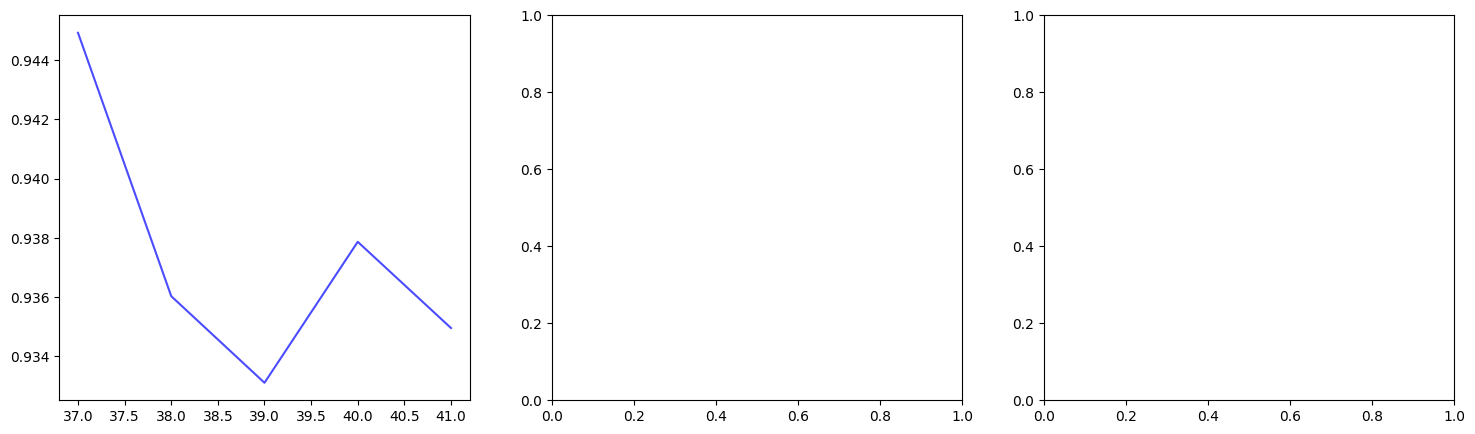

In [ ]:
import os
from pathlib import Path

# 1. Tworzenie modelu i callbacków
def create_model_and_callbacks():
    # Tworzenie modelu
    model = LitUNet(in_ch=3, lr=1e-3, dropout=0.2)
    
    # Callback do zbierania metryk
    metrics_callback = MetricsCallback()
    
    # Early stopping - zatrzymanie gdy val_dice nie rośnie przez 10 epok
    early_stopping = EarlyStopping(
        monitor='val_dice',
        patience=10,
        mode='max',
        verbose=True
    )
    
    # Checkpoint - zapisywanie modelu w każdej epoce
    checkpoint_callback = ModelCheckpoint(
        monitor='val_dice',
        dirpath='./checkpoints',
        filename='unet-{epoch:02d}-{val_dice:.3f}',
        save_top_k=-1,  # Zapisz wszystkie checkpointy
        every_n_epochs=1,  # Zapisuj w każdej epoce
        mode='max',
        save_last=True  # Zawsze zapisuj ostatni checkpoint jako last.ckpt
    )
    
    return model, metrics_callback, early_stopping, checkpoint_callback

# Sprawdź czy istnieje ostatni checkpoint
checkpoint_dir = Path('./checkpoints')
last_checkpoint = None

if checkpoint_dir.exists():
    # Szukaj ostatniego checkpointu
    checkpoint_files = list(checkpoint_dir.glob('*.ckpt'))
    if checkpoint_files:
        # Znajdź najnowszy checkpoint po numerze epoki
        latest_checkpoint = None
        latest_epoch = -1
        
        for checkpoint in checkpoint_files:
            # Sprawdź czy to plik last.ckpt
            if checkpoint.name == 'last.ckpt':
                latest_checkpoint = checkpoint
                break
            
            # Spróbuj wyciągnąć numer epoki z nazwy pliku
            try:
                epoch_num = int(checkpoint.stem.split('-')[1])
                if epoch_num > latest_epoch:
                    latest_epoch = epoch_num
                    latest_checkpoint = checkpoint
            except (ValueError, IndexError):
                continue
        
        if latest_checkpoint:
            last_checkpoint = str(latest_checkpoint)
            print(f"Znaleziono checkpoint: {last_checkpoint}")

# 2. Trening modelu
print("Rozpoczynanie treningu...")
model, metrics_callback, early_stopping, checkpoint_callback = create_model_and_callbacks()

# Konfiguracja trenera
trainer = Trainer(
    max_epochs=50,
    accelerator='auto',
    devices=1,
    callbacks=[metrics_callback, early_stopping, checkpoint_callback],
    precision=16,  # Mixed precision dla szybszego treningu
    log_every_n_steps=10,
    enable_progress_bar=True
)

# Trening - jeśli istnieje checkpoint, wznow z niego
if last_checkpoint:
    print(f"Wznawianie treningu z checkpointu: {last_checkpoint}")
    trainer.fit(model, dm, ckpt_path=last_checkpoint)
else:
    print("Rozpoczynanie treningu od początku")
    trainer.fit(model, dm)

Trening zakończony!


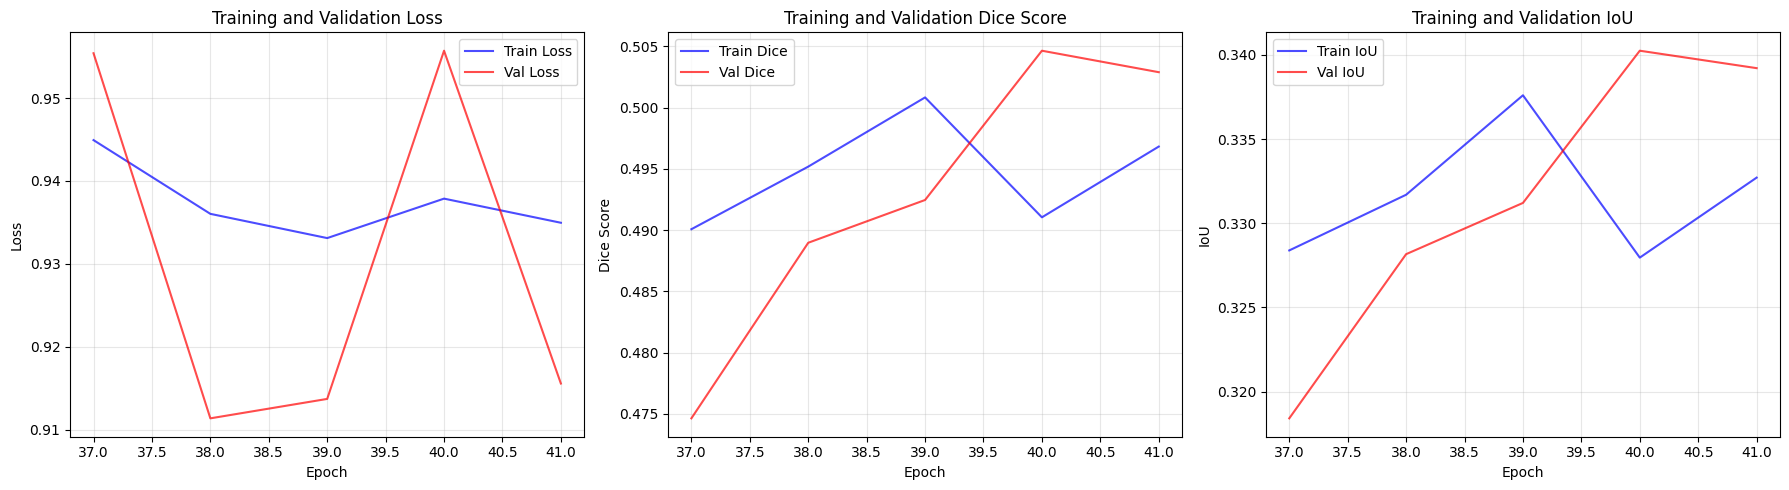


Testowanie najlepszego modelu...
Nie znaleziono zapisanego modelu, używanie ostatnio wytrenowanego modelu...
Train: 700 | Val: 200 | Test: 100
Testing DataLoader 0: 100%|██████████| 7/7 [00:18<00:00,  0.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_dice           0.4405671954154968
        test_iou            0.28593942523002625
        test_loss           0.9917294979095459
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.9917294979095459,
  'test_dice': 0.4405671954154968,
  'test_iou': 0.28593942523002625}]

In [16]:
print("Trening zakończony!")

# 3. Wizualizacja przebiegu treningu
def plot_training_metrics(metrics):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Loss
    axes[0].plot(metrics['epoch'], metrics['train_loss'][:len(metrics['epoch'])], 'b-', label='Train Loss', alpha=0.7)
    if metrics['val_loss']:
        axes[0].plot(metrics['epoch'], metrics['val_loss'][:len(metrics['epoch'])], 'r-', label='Val Loss', alpha=0.7)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Dice/F1 Score
    axes[1].plot(metrics['epoch'], metrics['train_dice'][:len(metrics['epoch'])], 'b-', label='Train Dice', alpha=0.7)
    if metrics['val_dice']:
        axes[1].plot(metrics['epoch'], metrics['val_dice'][:len(metrics['epoch'])], 'r-', label='Val Dice', alpha=0.7)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice Score')
    axes[1].set_title('Training and Validation Dice Score')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # IoU
    axes[2].plot(metrics['epoch'], metrics['train_iou'][:len(metrics['epoch'])], 'b-', label='Train IoU', alpha=0.7)
    if metrics['val_iou']:
        axes[2].plot(metrics['epoch'], metrics['val_iou'][:len(metrics['epoch'])], 'r-', label='Val IoU', alpha=0.7)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('IoU')
    axes[2].set_title('Training and Validation IoU')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Wywołanie wizualizacji
plot_training_metrics(metrics_callback.metrics)

# 4. Test na zbiorze testowym
print("\nTestowanie najlepszego modelu...")

# Znajdź najlepszy model na podstawie metryki val_dice
best_checkpoint = None
best_dice = -1

if checkpoint_dir.exists():
    checkpoint_files = list(checkpoint_dir.glob('*.ckpt'))
    for checkpoint in checkpoint_files:
        # Spróbuj wyciągnąć wartość dice z nazwy pliku
        try:
            dice_val = float(checkpoint.stem.split('-')[-1])
            if dice_val > best_dice:
                best_dice = dice_val
                best_checkpoint = checkpoint
        except (ValueError, IndexError):
            continue

if best_checkpoint:
    print(f"Ładowanie najlepszego modelu: {best_checkpoint} (Dice: {best_dice:.3f})")
    best_model = LitUNet.load_from_checkpoint(str(best_checkpoint))
else:
    print("Nie znaleziono zapisanego modelu, używanie ostatnio wytrenowanego modelu...")
    best_model = model

best_model.eval()

# Testowanie
trainer.test(best_model, dm)


Testowanie najlepszego modelu...
Nie znaleziono zapisanego modelu, używanie ostatniego modelu...
Train: 700 | Val: 200 | Test: 100
Testing DataLoader 0: 100%|██████████| 7/7 [00:18<00:00,  0.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_dice           0.4640219807624817
        test_iou            0.30508315563201904
        test_loss           0.9137436747550964
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Wizualizacja predykcji...


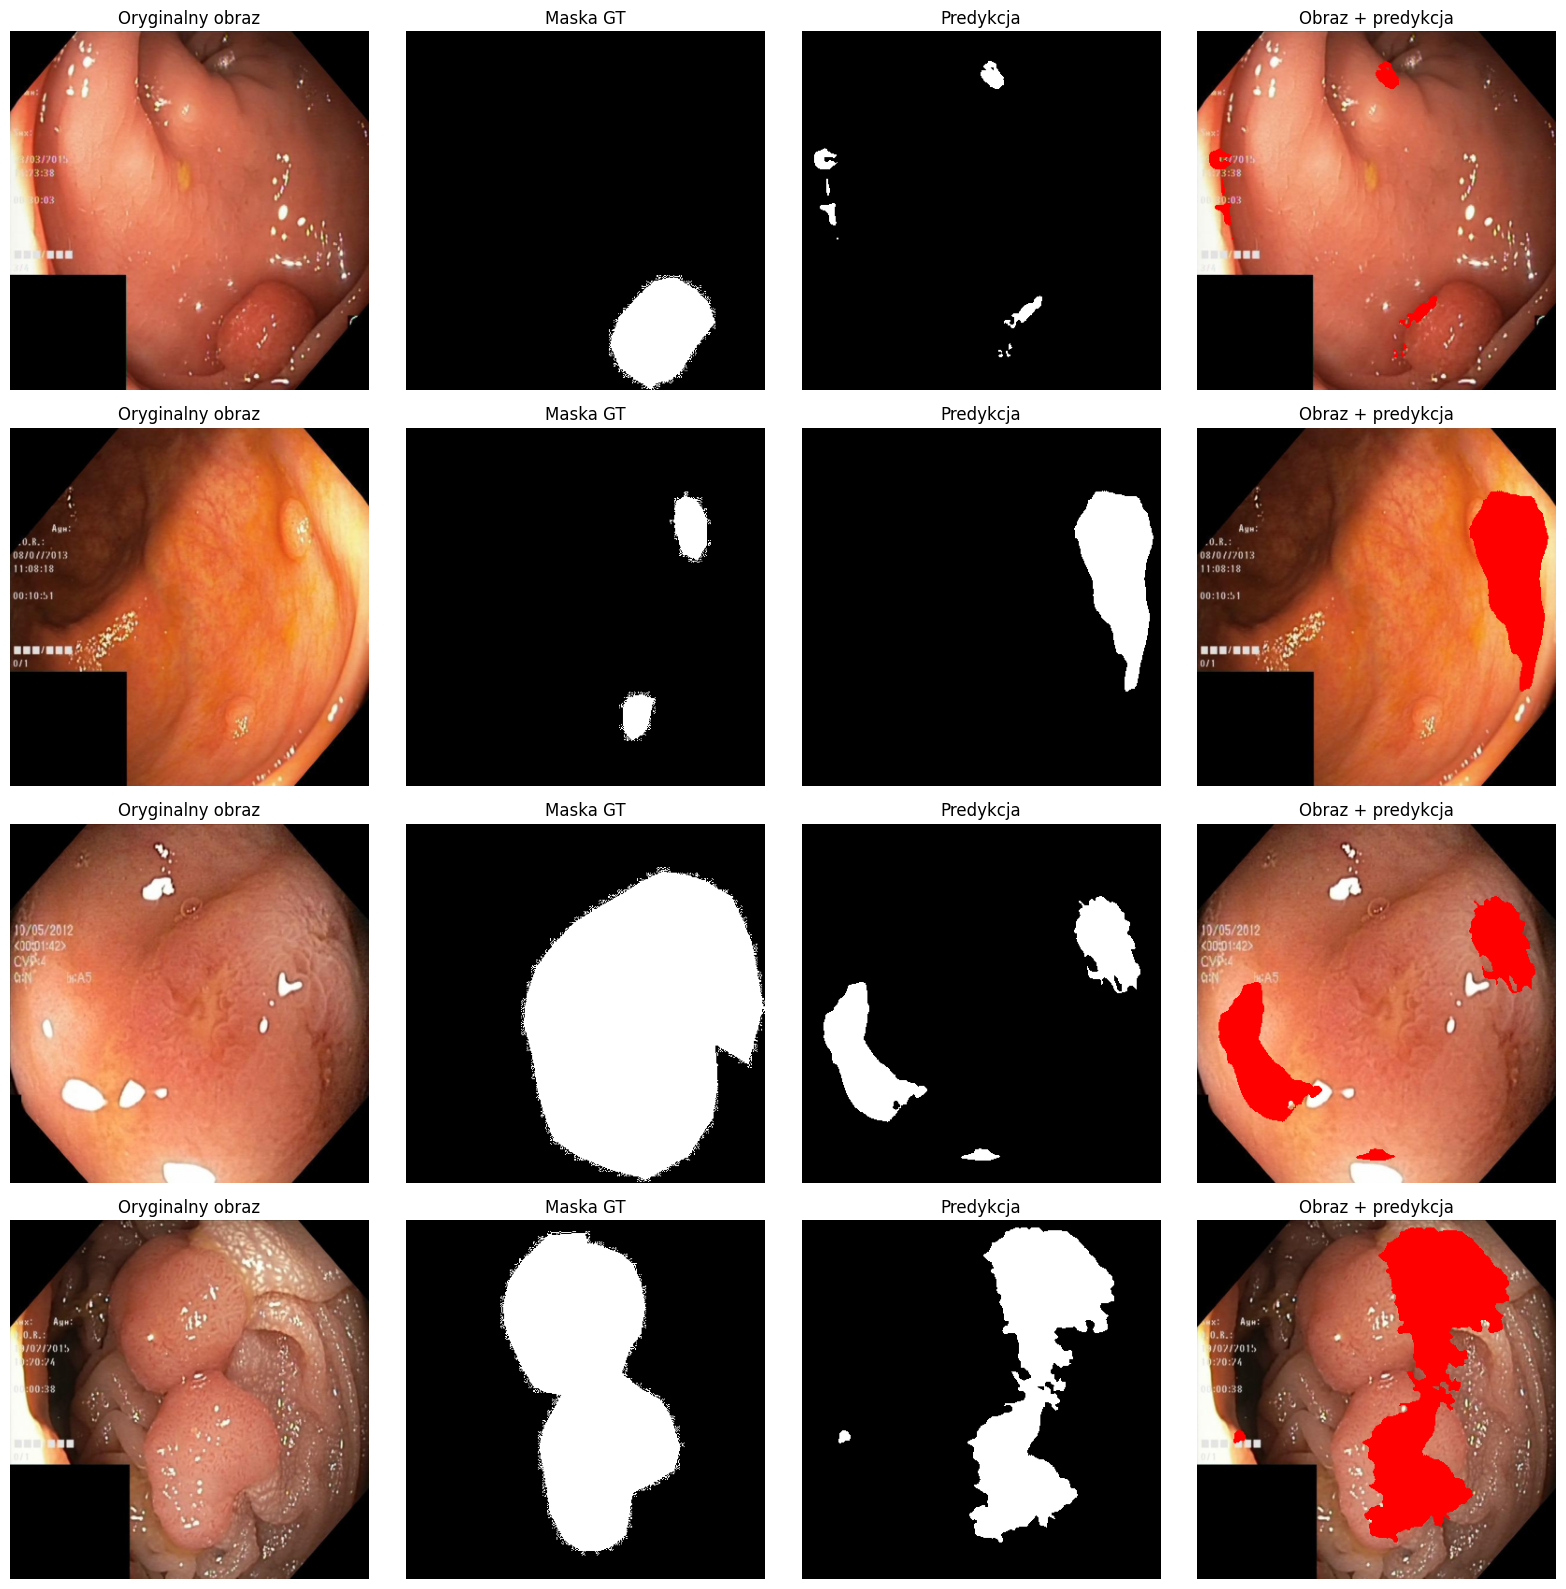


Metryki dla wizualizowanych przykładów:
Przykład 1: IoU = 0.039, Dice = 0.076
Przykład 2: IoU = 0.117, Dice = 0.209
Przykład 3: IoU = 0.070, Dice = 0.131
Przykład 4: IoU = 0.253, Dice = 0.404
Przykład 5: IoU = 0.034, Dice = 0.066
Przykład 6: IoU = 0.456, Dice = 0.626
Przykład 7: IoU = 0.000, Dice = 0.000
Przykład 8: IoU = 0.577, Dice = 0.732
Przykład 9: IoU = 0.006, Dice = 0.011
Przykład 10: IoU = 0.365, Dice = 0.535
Przykład 11: IoU = 0.019, Dice = 0.037
Przykład 12: IoU = 0.404, Dice = 0.576
Przykład 13: IoU = 0.397, Dice = 0.568
Przykład 14: IoU = 0.055, Dice = 0.104
Przykład 15: IoU = 0.067, Dice = 0.126
Przykład 16: IoU = 0.000, Dice = 0.000
Model zapisany do: ./final_model.pth


In [18]:

# 3. Wizualizacja przebiegu treningu
def plot_training_metrics(metrics):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    epochs = metrics['epoch']
    max_epoch = metrics['epoch'][-1]
    
    # Loss
    axes[0].plot(metrics['epoch'], metrics['train_loss'][:max_epoch], 'b-', label='Train Loss', alpha=0.7)
    axes[0].plot(metrics['epoch'], metrics['val_loss'][:max_epoch], 'r-', label='Val Loss', alpha=0.7)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Dice/F1 Score
    axes[1].plot(metrics['epoch'], metrics['train_dice'][:max_epoch], 'b-', label='Train Dice', alpha=0.7)
    axes[1].plot(metrics['epoch'], metrics['val_dice'][:max_epoch], 'r-', label='Val Dice', alpha=0.7)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice Score')
    axes[1].set_title('Training and Validation Dice Score')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # IoU
    axes[2].plot(metrics['epoch'], metrics['train_iou'][:max_epoch], 'b-', label='Train IoU', alpha=0.7)
    axes[2].plot(metrics['epoch'], metrics['val_iou'][:max_epoch], 'r-', label='Val IoU', alpha=0.7)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('IoU')
    axes[2].set_title('Training and Validation IoU')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Wywołanie wizualizacji
# plot_training_metrics(metrics_callback.metrics)

# 4. Test na zbiorze testowym
print("\nTestowanie najlepszego modelu...")

# # Wczytanie najlepszego modelu
# best_model_path = checkpoint_callback.best_model_path
# print(f"Ładowanie najlepszego modelu: {best_model_path}")

# if best_model_path:
#     # Wczytanie modelu
#     best_model = LitUNet.load_from_checkpoint("./checkpoints/" + best_model_path)
#     best_model.eval()
    
#     # Testowanie
#     trainer.test(best_model, dm)
# else:
print("Nie znaleziono zapisanego modelu, używanie ostatniego modelu...")
trainer.test(model, dm)

# 5. Wizualizacja predykcji
def visualize_predictions(model, datamodule, num_samples=4):
    """Wizualizacja predykcji modelu"""
    model.eval()
    
    # Pobranie batcha testowego
    test_loader = datamodule.test_dataloader()
    xb, yb = next(iter(test_loader))
    
    # Predykcje
    with torch.no_grad():
        logits = model(xb)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).int()
    
    # Konwersja tensorów do numpy
    xb_np = xb.cpu().numpy()
    yb_np = yb.cpu().numpy()
    preds_np = preds.cpu().numpy()
    probs_np = probs.cpu().numpy()
    
    # Wizualizacja
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        # Oryginalny obraz (denormalizacja)
        img = ((xb_np[i].transpose(1, 2, 0) * 0.5) + 0.5).clip(0, 1)
        
        # Maska GT
        gt_mask = yb_np[i, 0]
        
        # Predykcja
        pred_mask = preds_np[i, 0]
        
        # Obraz z nałożoną predykcją
        overlay = img.copy()
        mask_pred = preds_np[i, 0] > 0.5
        overlay[mask_pred] = [1.0, 0.0, 0.0]  # Czerwony kolor dla predykcji
        
        # Wyświetlanie
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Oryginalny obraz')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(gt_mask, cmap='gray')
        axes[i, 1].set_title('Maska GT')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_mask, cmap='gray')
        axes[i, 2].set_title('Predykcja')
        axes[i, 2].axis('off')
        
        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title('Obraz + predykcja')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return xb_np, yb_np, preds_np, probs_np

# Wizualizacja predykcji
print("\nWizualizacja predykcji...")
xb_np, yb_np, preds_np, probs_np = visualize_predictions(best_model if best_model_path else model, dm, num_samples=4)

# Dodatkowa analiza - wyświetlenie metryk dla wizualizowanych przykładów
def calculate_sample_metrics(gt_masks, pred_masks):
    """Oblicza metryki dla poszczególnych próbek"""
    from sklearn.metrics import jaccard_score, f1_score
    
    sample_metrics = []
    for i in range(len(gt_masks)):
        gt_flat = gt_masks[i].flatten()
        pred_flat = pred_masks[i].flatten()
        
        iou = jaccard_score(gt_flat, pred_flat, zero_division=0)
        dice = f1_score(gt_flat, pred_flat, zero_division=0)
        
        sample_metrics.append({'iou': iou, 'dice': dice})
    
    return sample_metrics

# Obliczenie metryk dla wizualizowanych przykładów
sample_metrics = calculate_sample_metrics(yb_np[:, 0], preds_np[:, 0])

print("\nMetryki dla wizualizowanych przykładów:")
for i, metrics in enumerate(sample_metrics):
    print(f"Przykład {i+1}: IoU = {metrics['iou']:.3f}, Dice = {metrics['dice']:.3f}")

# Zapisanie modelu do późniejszego użycia
def save_final_model(model, path='./final_model.pth'):
    """Zapisuje wag modelu do pliku"""
    torch.save(model.model.state_dict(), path)
    print(f"Model zapisany do: {path}")

# Zapisanie finalnego modelu
save_final_model(best_model if best_model_path else model)

def compare_precision():
    """Porównanie treningu z różnymi precyzjami numerycznymi"""
    precisions = [32, 16]
    results = {}
    
    for precision in precisions:
        print(f"\n--- Trening z precyzją {precision} ---")
        
        # Resetowanie seeda dla porównywalności
        if SEED is not None:
            set_seed(SEED)
        
        # Tworzenie modelu i callbacków
        model = LitUNet(in_ch=3, lr=1e-3, dropout=0.2)
        metrics_callback = MetricsCallback()
        
        # Krótszy trening dla porównania
        trainer = Trainer(
            max_epochs=10,  # Tylko 10 epok dla szybkiego porównania
            accelerator='auto',
            devices=1,
            callbacks=[metrics_callback],
            precision=precision,
            enable_progress_bar=False
        )
        
        # Trening
        trainer.fit(model, dm)
        
        results[precision] = {
            'metrics': metrics_callback.metrics,
            'final_val_dice': metrics_callback.metrics['val_dice'][-1] if metrics_callback.metrics['val_dice'] else 0
        }
        
        print(f"Final Val Dice (precision {precision}): {results[precision]['final_val_dice']:.4f}")
    
    return results

# Uruchomienie porównania (opcjonalnie)
# precision_results = compare_precision()

## Zadanie 4 – Transfer Learning: U-Net z pre-trained ResNet Encoder

Znowu wykorzystamy transfer learning do zbudowania sieci o większej skuteczności. Zamiast używać całej nauczonej wcześniej sieci wyciągniemy tylko kilka warstw i użyjemy ich w enkoderze modelu U-Net.

1. **ResNetEncoder:**
   - Zaimplementuj klasę `ResNetEncoder`, która dziedziczy po `nn.Module`.
   - W `__init__` przyjmij: `pretrained=True` (czy ładować pretrenowane wagi), `freeze_encoder=False` (czy wczytane wagi mają być zamrożone).
   - Wczytaj pretrained ResNet18: `models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)`.
   - Wyciągnij warstwy enkodera:
     - `resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool` – początkowe warstwy.
     - `resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4` – bloki ResNet (64, 128, 256, 512 kanałów).
   - Jeśli `freeze_encoder=True`, ustaw wszystkie parametry na `requires_grad=False` wewnątrz bloku `for param in self.parameters():`
   - W metodzie `forward(x)` przepuść dane przez warstwy i zwróć 5 tensorów skip connections: `x1` (po conv1), `x2` (po layer1), `x3` (po layer2), `x4` (po layer3), `x5` (po layer4/bottleneck).

2. **UNetResNet:**
   - Zaimplementuj klasę `UNetResNet`, która dziedziczy po `nn.Module`.
   - W `__init__` przyjmij: `pretrained=True`, `freeze_encoder=False`, `dropout`.
   - Stwórz encoder: `self.encoder = ResNetEncoder(pretrained, freeze_encoder)`.
   - Zbuduj decoder (podobnie jak w poprzednim zadaniu):
     - `ConvTranspose2d` upsampling z bottleneck (u1).
     - `DoubleConv` pamiętaj o konkatenacji wyjścia z u1 i skip connection z x4.
     - `ConvTranspose2d` (u2).
     - `DoubleConv` u2 + x3.
     - `ConvTranspose2d` (u3).
     - `DoubleConv` u3 + x2.
     - `ConvTranspose2d` (u4).
     - `DoubleConv` u4 + x1.
     - `ConvTranspose2d` powrót do orygionalej rozdzielczości.
     - `DoubleConv`.
   - Warstwa wyjściowa `Conv2d` z jednym kanałem wyjściowym o rozmiarze 1x1.
   - W metodzie `forward(x)`:
     - Wywołaj encoder: `x1, x2, x3, x4, x5 = self.encoder(x)`.
     - Przepuść przez decoder i skip connections.
     - Zwróć logity.

3. **LitUNetResNet:**
   - Zaimplementuj Lightning wrapper analogicznie do `LitUNet`.
   - Dodaj metody pomocnicze:
     - `freeze_encoder()`: zamraża wagi enkodera (tylko decoder będzie trenowany).
     - `unfreeze_encoder()`: odmraża encoder (cała sieć będzie trenowana).

4. **Test architektury:**
   - Stwórz instancję `UNetResNet`.
   - Przepuść losowy tensor przez sieć i sprawdź kształt wyjścia.
   - Wyświetl osobno liczbę wszystkich oraz liczbę uczonych parametrów `sum(p.numel() for p in model_tl.parameters() if p.requires_grad)`

In [ ]:
# 1. ResNetEncoder
class ResNetEncoder(nn.Module):
    def __init__(self, pretrained=True, freeze_encoder=False):
        super().__init__()
        
        # Wczytanie pretrenowanego ResNet18
        resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        
        # Wyciągnięcie warstw enkodera
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        
        self.layer1 = resnet.layer1  # 64 kanałów
        self.layer2 = resnet.layer2  # 128 kanałów
        self.layer3 = resnet.layer3  # 256 kanałów
        self.layer4 = resnet.layer4  # 512 kanałów
        
        # Zamrożenie enkodera jeśli wymagane
        if freeze_encoder:
            for param in self.parameters():
                param.requires_grad = False
    
    def forward(self, x):
        # Początkowe warstwy
        x1 = self.conv1(x)      # [B, 64, H/2, W/2]
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        
        x2 = self.maxpool(x1)   # [B, 64, H/4, W/4]
        x2 = self.layer1(x2)    # [B, 64, H/4, W/4]
        
        x3 = self.layer2(x2)    # [B, 128, H/8, W/8]
        x4 = self.layer3(x3)    # [B, 256, H/16, W/16]
        x5 = self.layer4(x4)    # [B, 512, H/32, W/32]
        
        return x1, x2, x3, x4, x5

# 2. UNetResNet
class UNetResNet(nn.Module):
    def __init__(self, pretrained=True, freeze_encoder=False, dropout=0.0):
        super().__init__()
        
        # Encoder - pretrenowany ResNet
        self.encoder = ResNetEncoder(pretrained=pretrained, freeze_encoder=freeze_encoder)
        
        # Decoder
        # Upsampling z bottleneck (x5: 512 kanałów) do 256
        self.u1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.c1 = DoubleConv(256 + 256, 256, dropout)  # + x4 (256 kanałów)
        
        # Upsampling do 128
        self.u2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.c2 = DoubleConv(128 + 128, 128, dropout)  # + x3 (128 kanałów)
        
        # Upsampling do 64
        self.u3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.c3 = DoubleConv(64 + 64, 64, dropout)     # + x2 (64 kanały)
        
        # Upsampling do 64 (z x1)
        self.u4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.c4 = DoubleConv(64 + 64, 64, dropout)     # + x1 (64 kanały)
        
        # Final upsampling do oryginalnej rozdzielczości
        self.u5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.c5 = DoubleConv(32, 32, dropout)
        
        # Warstwa wyjściowa
        self.out = nn.Conv2d(32, 1, kernel_size=1)
    
    def forward(self, x):
        # Encoder
        x1, x2, x3, x4, x5 = self.encoder(x)
        
        # Decoder z skip connections
        u1 = self.u1(x5)                    # [B, 256, H/16, W/16]
        c1 = self.c1(torch.cat([u1, x4], dim=1))  # [B, 256, H/16, W/16]
        
        u2 = self.u2(c1)                    # [B, 128, H/8, W/8]
        c2 = self.c2(torch.cat([u2, x3], dim=1))  # [B, 128, H/8, W/8]
        
        u3 = self.u3(c2)                    # [B, 64, H/4, W/4]
        c3 = self.c3(torch.cat([u3, x2], dim=1))  # [B, 64, H/4, W/4]
        
        u4 = self.u4(c3)                    # [B, 64, H/2, W/2]
        c4 = self.c4(torch.cat([u4, x1], dim=1))  # [B, 64, H/2, W/2]
        
        u5 = self.u5(c4)                    # [B, 32, H, W]
        c5 = self.c5(u5)                    # [B, 32, H, W]
        
        # Wyjście
        return self.out(c5)

# 3. Lightning wrapper dla UNetResNet
class LitUNetResNet(LightningModule):
    def __init__(self, pretrained=True, freeze_encoder=False, lr=1e-3, dropout=0.0):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = UNetResNet(
            pretrained=pretrained, 
            freeze_encoder=freeze_encoder, 
            dropout=dropout
        )
        
        # Funkcje straty
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.dice_loss = DiceLoss()
        
        # Metryki
        self.train_iou = BinaryJaccardIndex()
        self.val_iou = BinaryJaccardIndex()
        self.test_iou = BinaryJaccardIndex()
        
        self.train_f1 = BinaryF1Score()
        self.val_f1 = BinaryF1Score()
        self.test_f1 = BinaryF1Score()
        
        self.lr = lr
        self.freeze_encoder_flag = freeze_encoder
    
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        # Jeśli encoder jest zamrożony, optymalizujemy tylko decoder
        if self.freeze_encoder_flag:
            parameters = []
            for name, param in self.model.named_parameters():
                if 'encoder' not in name:  # Tylko parametry dekodera
                    parameters.append(param)
        else:
            parameters = self.parameters()
        
        optimizer = torch.optim.Adam(parameters, lr=self.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=10, eta_min=1e-5
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler
        }
    
    def freeze_encoder(self):
        """Zamraża wagii enkodera"""
        for param in self.model.encoder.parameters():
            param.requires_grad = False
        self.freeze_encoder_flag = True
        print("Encoder zamrożony - tylko decoder będzie trenowany")
    
    def unfreeze_encoder(self):
        """Odmraża wagi enkodera"""
        for param in self.model.encoder.parameters():
            param.requires_grad = True
        self.freeze_encoder_flag = False
        print("Encoder odmrożony - cała sieć będzie trenowana")
    
    def _shared_step(self, batch, batch_idx, stage):
        x, y = batch
        logits = self(x)
        
        # Obliczanie strat
        bce_loss = self.bce_loss(logits, y)
        dice_loss = self.dice_loss(logits, y)
        total_loss = bce_loss + dice_loss
        
        # Obliczanie metryk
        with torch.no_grad():
            preds = (torch.sigmoid(logits) > 0.5).int()
            y_int = y.int()
            
            if stage == 'train':
                iou = self.train_iou(preds, y_int)
                f1 = self.train_f1(preds, y_int)
            elif stage == 'val':
                iou = self.val_iou(preds, y_int)
                f1 = self.val_f1(preds, y_int)
            else:  # test
                iou = self.test_iou(preds, y_int)
                f1 = self.test_f1(preds, y_int)
        
        # Logowanie
        self.log(f'{stage}_loss', total_loss, on_epoch=True, prog_bar=True)
        self.log(f'{stage}_dice', f1, on_epoch=True, prog_bar=True)
        self.log(f'{stage}_iou', iou, on_epoch=True, prog_bar=True)
        
        return total_loss
    
    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, batch_idx, 'train')
    
    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, batch_idx, 'val')
    
    def test_step(self, batch, batch_idx):
        return self._shared_step(batch, batch_idx, 'test')

# 4. Test architektury
def test_resnet_unet():
    print("Testowanie architektury UNetResNet...")
    
    # Tworzenie modelu
    model_tl = UNetResNet(pretrained=True, freeze_encoder=False, dropout=0.1)
    
    # Test forward pass
    test_input = torch.randn(2, 3, 384, 384)
    with torch.no_grad():
        output = model_tl(test_input)
    
    print(f"Input shape: {test_input.shape}")
    print(f"Output shape: {output.shape}")
    
    # Liczba parametrów
    total_params = sum(p.numel() for p in model_tl.parameters())
    trainable_params = sum(p.numel() for p in model_tl.parameters() if p.requires_grad)
    
    print(f"Całkowita liczba parametrów: {total_params:,}")
    print(f"Liczba uczonych parametrów: {trainable_params:,}")
    print(f"Procent uczonych parametrów: {trainable_params/total_params*100:.2f}%")
    
    # Test z zamrożonym enkoderem
    print("\nTest z zamrożonym enkoderem...")
    model_frozen = UNetResNet(pretrained=True, freeze_encoder=True, dropout=0.1)
    
    total_params_frozen = sum(p.numel() for p in model_frozen.parameters())
    trainable_params_frozen = sum(p.numel() for p in model_frozen.parameters() if p.requires_grad)
    
    print(f"Całkowita liczba parametrów: {total_params_frozen:,}")
    print(f"Liczba uczonych parametrów: {trainable_params_frozen:,}")
    print(f"Procent uczonych parametrów: {trainable_params_frozen/total_params_frozen*100:.2f}%")
    
    return model_tl, model_frozen

# Uruchomienie testu
if __name__ == '__main__':
    model_tl, model_frozen = test_resnet_unet()

Testowanie architektury UNetResNet...
Input shape: torch.Size([2, 3, 384, 384])
Output shape: torch.Size([2, 1, 384, 384])
Całkowita liczba parametrów: 14,344,513
Liczba uczonych parametrów: 14,344,513
Procent uczonych parametrów: 100.00%

Test z zamrożonym enkoderem...
Całkowita liczba parametrów: 14,344,513
Liczba uczonych parametrów: 3,168,001
Procent uczonych parametrów: 22.09%


## Zadanie 5 – Dwuetapowy Transfer Learning: Frozen Encoder

Trening chcemy wykonać podobnie jak w poprzednim ćwiczeniu, czyli zaczynamy od zamrożonych wag z transfer learningu, a potem wykonujemy fine-tuning. Proces treningu jest taki sam jak dla naszej wcześniejszej sieci.

**Trening z zamrożonym encoderem:**
1. Stwórz obiekt klasy `LitUNetResNet` z pretrenowanymi i zamrożonymi wagami.
2. Stwórz callbacki: `MetricsCallback`, `EarlyStopping`, `ModelCheckpoint`.
3. Stwórz `Trainer`.
4. Wywołaj trening sieci wywołując metodę `fit`
5. Wyświetl najlepszy checkpoint i val_dice.
6. Sprawdź oraz wyświetl metryki (3 wykresy: loss, dice, iou) podobnie jak we wcześniejszym treningu.
7. Wczytaj najlepszy model sieci i wykonaj dla niego testy na zbiorze testowym.
8. Wyświetl przykładowe predykcje (4 obrazy × 4 kolumny).

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | UNetResNet         | 14.3 M | train
1 | bce_loss  | BCEWithLogitsLoss  | 0      | train
2 | dice_loss | DiceLoss           | 0      | train
3 | train_iou | BinaryJaccardIndex | 0      | train
4 | val_iou   | BinaryJaccardIndex | 0      | train
5 | test_iou  | BinaryJaccardIndex | 0      | train
6 | train_f1  | BinaryF1Score      | 0      | train
7 | val_f1    | BinaryF1Score      | 0      | train
8 | test_f1   | BinaryF1Score      | 0      | train
---------------------------------------------------------
3.2 M     Trainable params
11.2 M    Non-trainable params
14.3 M    Total params
57.378    Total estimated model params size (MB)
131       Modules in train mode
0         Modules in eval mode


=== ETAP 1: Trening z zamrożonym enkoderem ===
Rozpoczynanie treningu zamrożonego modelu od początku
Train: 700 | Val: 200 | Test: 100
Epoch 0: 100%|██████████| 44/44 [01:26<00:00,  0.51it/s, v_num=7, train_loss_step=0.922, train_dice_step=0.705, train_iou_step=0.544, val_loss=0.884, val_dice=0.697, val_iou=0.536, train_loss_epoch=1.100, train_dice_epoch=0.626, train_iou_epoch=0.467]

Metric val_dice improved. New best score: 0.697


Epoch 2: 100%|██████████| 44/44 [01:33<00:00,  0.47it/s, v_num=7, train_loss_step=0.678, train_dice_step=0.723, train_iou_step=0.566, val_loss=0.661, val_dice=0.743, val_iou=0.594, train_loss_epoch=0.699, train_dice_epoch=0.745, train_iou_epoch=0.597]

Metric val_dice improved by 0.046 >= min_delta = 0.0. New best score: 0.743


Epoch 3: 100%|██████████| 44/44 [01:35<00:00,  0.46it/s, v_num=7, train_loss_step=0.724, train_dice_step=0.669, train_iou_step=0.503, val_loss=0.581, val_dice=0.776, val_iou=0.636, train_loss_epoch=0.617, train_dice_epoch=0.762, train_iou_epoch=0.619]

Metric val_dice improved by 0.033 >= min_delta = 0.0. New best score: 0.776


Epoch 5: 100%|██████████| 44/44 [01:34<00:00,  0.47it/s, v_num=7, train_loss_step=0.375, train_dice_step=0.856, train_iou_step=0.749, val_loss=0.505, val_dice=0.783, val_iou=0.645, train_loss_epoch=0.507, train_dice_epoch=0.792, train_iou_epoch=0.658]

Metric val_dice improved by 0.007 >= min_delta = 0.0. New best score: 0.783


Epoch 6: 100%|██████████| 44/44 [01:34<00:00,  0.46it/s, v_num=7, train_loss_step=0.372, train_dice_step=0.861, train_iou_step=0.756, val_loss=0.467, val_dice=0.797, val_iou=0.665, train_loss_epoch=0.460, train_dice_epoch=0.809, train_iou_epoch=0.682]

Metric val_dice improved by 0.015 >= min_delta = 0.0. New best score: 0.797


Epoch 7: 100%|██████████| 44/44 [01:34<00:00,  0.46it/s, v_num=7, train_loss_step=0.529, train_dice_step=0.740, train_iou_step=0.587, val_loss=0.466, val_dice=0.798, val_iou=0.666, train_loss_epoch=0.452, train_dice_epoch=0.811, train_iou_epoch=0.684]

Metric val_dice improved by 0.000 >= min_delta = 0.0. New best score: 0.798


Epoch 8: 100%|██████████| 44/44 [01:30<00:00,  0.48it/s, v_num=7, train_loss_step=0.446, train_dice_step=0.835, train_iou_step=0.717, val_loss=0.446, val_dice=0.805, val_iou=0.677, train_loss_epoch=0.424, train_dice_epoch=0.826, train_iou_epoch=0.707]

Metric val_dice improved by 0.008 >= min_delta = 0.0. New best score: 0.805


Epoch 9: 100%|██████████| 44/44 [01:31<00:00,  0.48it/s, v_num=7, train_loss_step=0.365, train_dice_step=0.861, train_iou_step=0.756, val_loss=0.442, val_dice=0.808, val_iou=0.681, train_loss_epoch=0.400, train_dice_epoch=0.836, train_iou_epoch=0.720]

Metric val_dice improved by 0.003 >= min_delta = 0.0. New best score: 0.808


Epoch 10: 100%|██████████| 44/44 [01:31<00:00,  0.48it/s, v_num=7, train_loss_step=0.298, train_dice_step=0.900, train_iou_step=0.818, val_loss=0.436, val_dice=0.810, val_iou=0.683, train_loss_epoch=0.395, train_dice_epoch=0.840, train_iou_epoch=0.725]

Metric val_dice improved by 0.002 >= min_delta = 0.0. New best score: 0.810


Epoch 14: 100%|██████████| 44/44 [01:31<00:00,  0.48it/s, v_num=7, train_loss_step=0.316, train_dice_step=0.862, train_iou_step=0.758, val_loss=0.424, val_dice=0.812, val_iou=0.687, train_loss_epoch=0.399, train_dice_epoch=0.829, train_iou_epoch=0.710]

Metric val_dice improved by 0.002 >= min_delta = 0.0. New best score: 0.812


Epoch 19: 100%|██████████| 44/44 [01:31<00:00,  0.48it/s, v_num=7, train_loss_step=0.585, train_dice_step=0.742, train_iou_step=0.590, val_loss=0.484, val_dice=0.778, val_iou=0.640, train_loss_epoch=0.395, train_dice_epoch=0.822, train_iou_epoch=0.700]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 44/44 [01:31<00:00,  0.48it/s, v_num=7, train_loss_step=0.585, train_dice_step=0.742, train_iou_step=0.590, val_loss=0.484, val_dice=0.778, val_iou=0.640, train_loss_epoch=0.395, train_dice_epoch=0.822, train_iou_epoch=0.700]
Trening z zamrożonym enkoderem zakończony!

--- Wizualizacja metryk dla etapu 1 (zamrożony encoder) ---


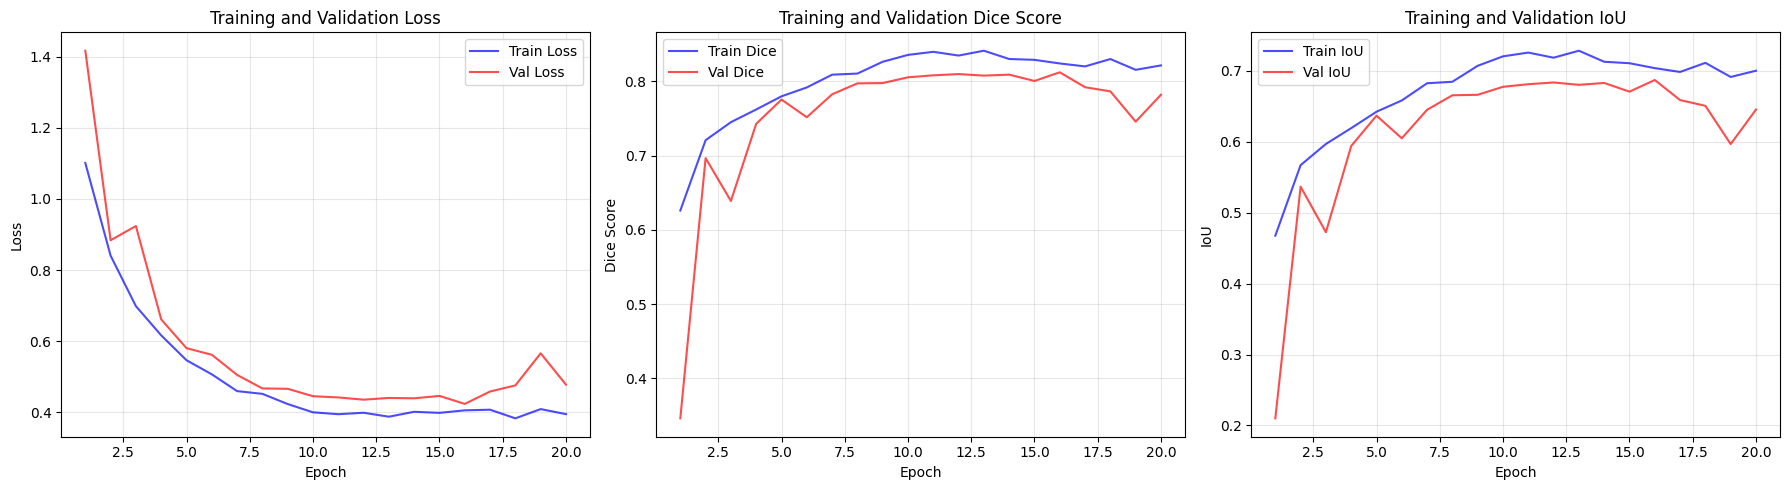


--- Testowanie najlepszego modelu z etapu 1 ---
Nie znaleziono zapisanego zamrożonego modelu, używanie ostatnio wytrenowanego modelu...
Wyniki testowania zamrożonego modelu:
Train: 700 | Val: 200 | Test: 100
Testing DataLoader 0: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_dice           0.8190794587135315
        test_iou            0.6956590414047241
        test_loss           0.37731239199638367
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Wizualizacja predykcji dla etapu 1 ---


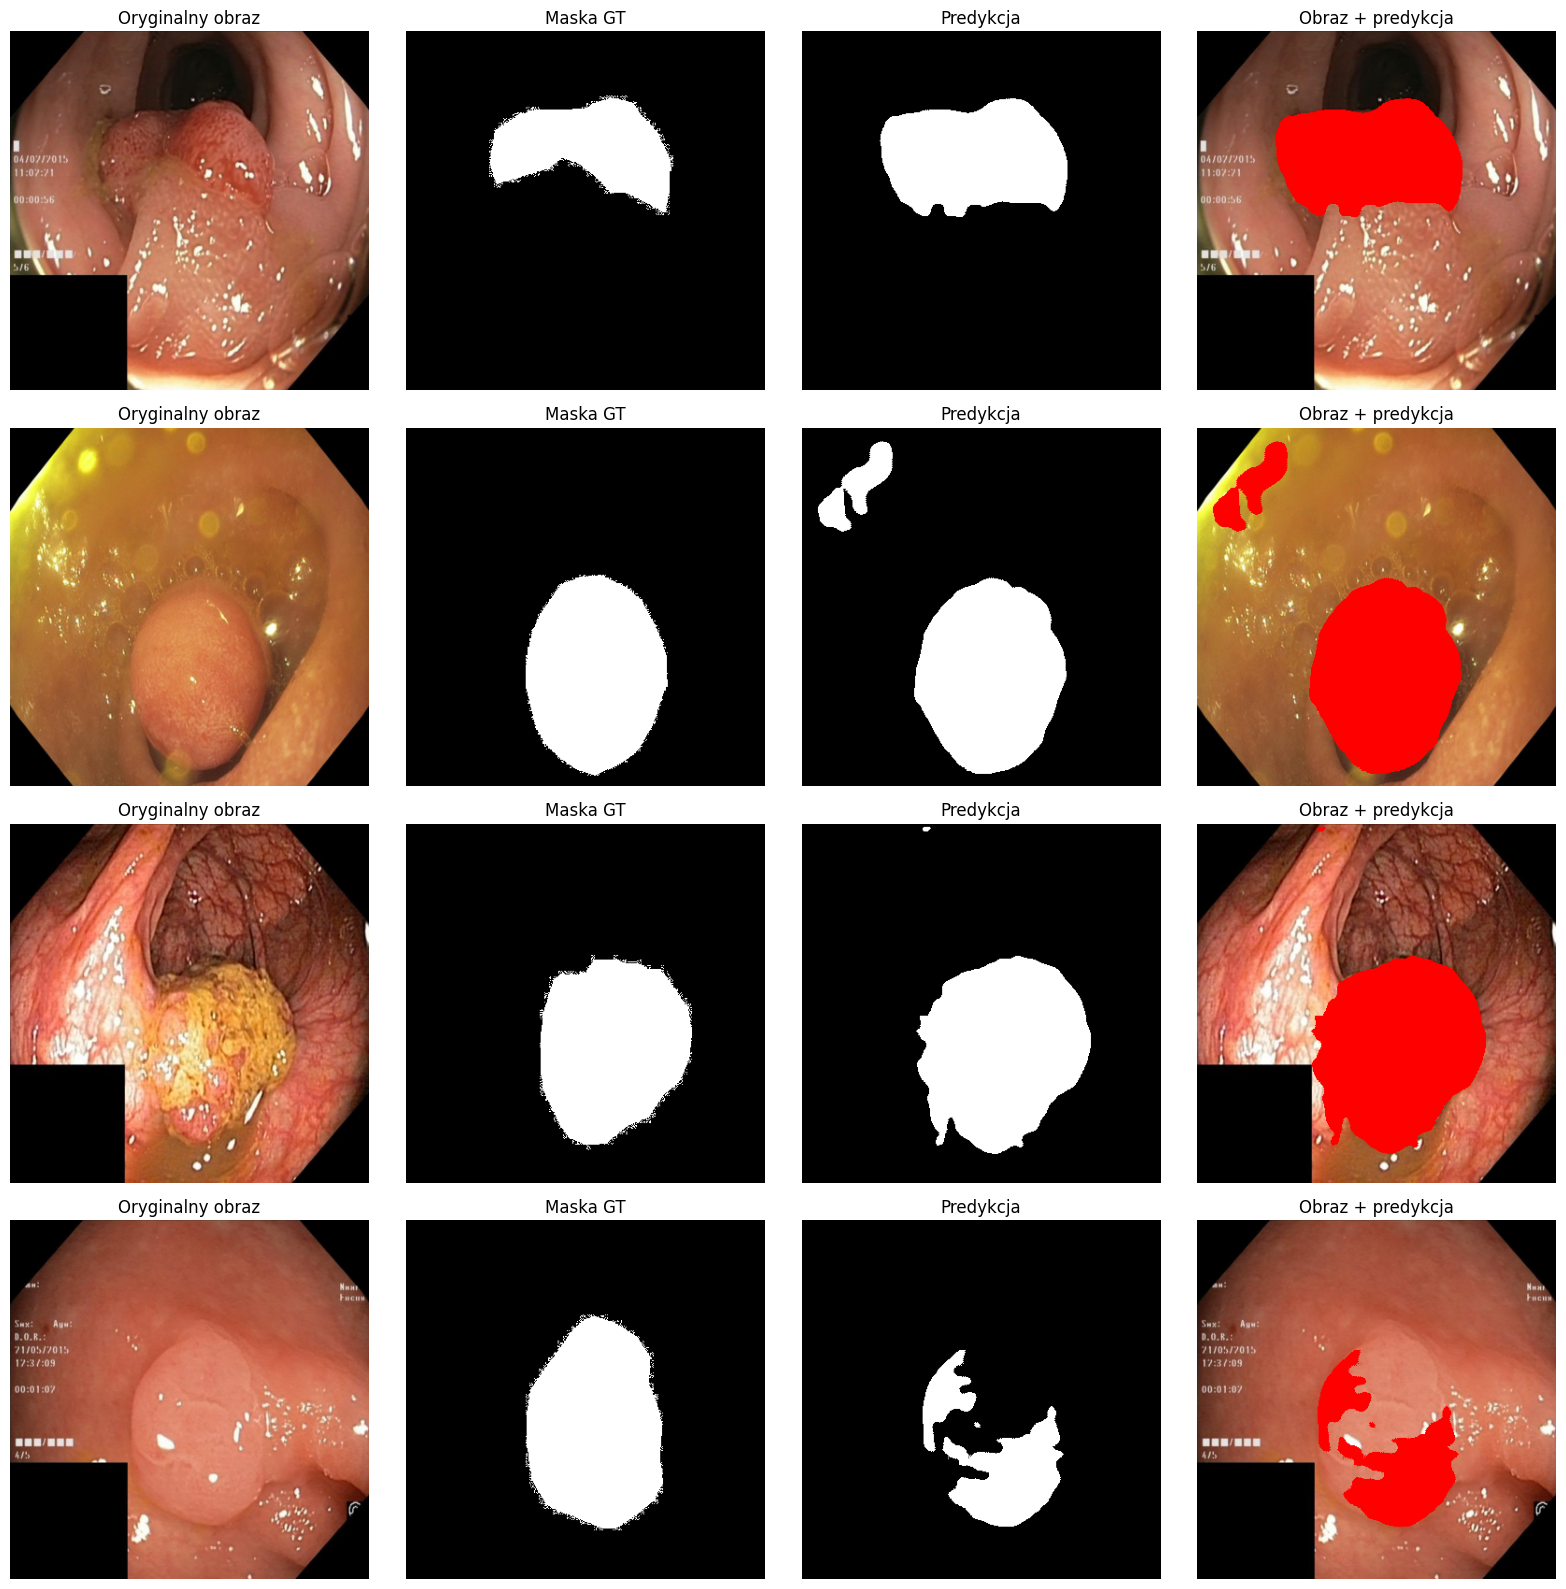

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params | Mode
--------------------------------------------------------
0 | model     | UNetResNet         | 14.3 M | eval
1 | bce_loss  | BCEWithLogitsLoss  | 0      | eval
2 | dice_loss | DiceLoss           | 0      | eval
3 | train_iou | BinaryJaccardIndex | 0      | eval
4 | val_iou   | BinaryJaccardIndex | 0      | eval
5 | test_iou  | BinaryJaccardIndex | 0      | eval
6 | train_f1  | BinaryF1Score      | 0      | eval
7 | val_f1    | BinaryF1Score      | 0      | eval
8 | test_f1   | BinaryF1Score      | 0      | eval
--------------------------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.378    Total estimated model params size (MB)
0         Modules in train mode
131       Modules in eval mode



=== ETAP 2: Fine-tuning (odmrożony encoder) ===
Używam ostatniego modelu z etapu 1 jako bazy do fine-tuningu...
Encoder odmrożony - cała sieć będzie trenowana
Rozpoczynanie fine-tuningu od początku
Train: 700 | Val: 200 | Test: 100


/home/jrosa/AGH_FILES/PiAOM-2025W/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:527: Found 132 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Epoch 0: 100%|██████████| 44/44 [01:30<00:00,  0.49it/s, v_num=8, train_loss_step=0.428, train_dice_step=0.816, train_iou_step=0.689, val_loss=0.462, val_dice=0.789, val_iou=0.655, train_loss_epoch=0.491, train_dice_epoch=0.763, train_iou_epoch=0.632]

Metric val_dice improved. New best score: 0.789


Epoch 1: 100%|██████████| 44/44 [01:32<00:00,  0.47it/s, v_num=8, train_loss_step=0.290, train_dice_step=0.880, train_iou_step=0.785, val_loss=0.426, val_dice=0.806, val_iou=0.677, train_loss_epoch=0.352, train_dice_epoch=0.833, train_iou_epoch=0.717]

Metric val_dice improved by 0.016 >= min_delta = 0.0. New best score: 0.806


Epoch 2: 100%|██████████| 44/44 [01:32<00:00,  0.48it/s, v_num=8, train_loss_step=0.581, train_dice_step=0.731, train_iou_step=0.577, val_loss=0.389, val_dice=0.826, val_iou=0.704, train_loss_epoch=0.344, train_dice_epoch=0.838, train_iou_epoch=0.724]

Metric val_dice improved by 0.020 >= min_delta = 0.0. New best score: 0.826


Epoch 3: 100%|██████████| 44/44 [01:31<00:00,  0.48it/s, v_num=8, train_loss_step=0.298, train_dice_step=0.863, train_iou_step=0.760, val_loss=0.366, val_dice=0.835, val_iou=0.718, train_loss_epoch=0.276, train_dice_epoch=0.870, train_iou_epoch=0.772]

Metric val_dice improved by 0.010 >= min_delta = 0.0. New best score: 0.835


Epoch 6: 100%|██████████| 44/44 [01:31<00:00,  0.48it/s, v_num=8, train_loss_step=0.150, train_dice_step=0.924, train_iou_step=0.859, val_loss=0.348, val_dice=0.846, val_iou=0.734, train_loss_epoch=0.191, train_dice_epoch=0.911, train_iou_epoch=0.837]

Metric val_dice improved by 0.011 >= min_delta = 0.0. New best score: 0.846


Epoch 7: 100%|██████████| 44/44 [01:33<00:00,  0.47it/s, v_num=8, train_loss_step=0.230, train_dice_step=0.910, train_iou_step=0.834, val_loss=0.344, val_dice=0.847, val_iou=0.736, train_loss_epoch=0.166, train_dice_epoch=0.923, train_iou_epoch=0.857]

Metric val_dice improved by 0.001 >= min_delta = 0.0. New best score: 0.847


Epoch 8: 100%|██████████| 44/44 [01:32<00:00,  0.48it/s, v_num=8, train_loss_step=0.188, train_dice_step=0.912, train_iou_step=0.838, val_loss=0.334, val_dice=0.856, val_iou=0.749, train_loss_epoch=0.149, train_dice_epoch=0.931, train_iou_epoch=0.872] 

Metric val_dice improved by 0.009 >= min_delta = 0.0. New best score: 0.856


Epoch 10: 100%|██████████| 44/44 [01:32<00:00,  0.48it/s, v_num=8, train_loss_step=0.103, train_dice_step=0.947, train_iou_step=0.900, val_loss=0.329, val_dice=0.856, val_iou=0.750, train_loss_epoch=0.133, train_dice_epoch=0.938, train_iou_epoch=0.884] 

Metric val_dice improved by 0.001 >= min_delta = 0.0. New best score: 0.856


Epoch 13: 100%|██████████| 44/44 [01:32<00:00,  0.48it/s, v_num=8, train_loss_step=0.154, train_dice_step=0.941, train_iou_step=0.888, val_loss=0.334, val_dice=0.857, val_iou=0.750, train_loss_epoch=0.135, train_dice_epoch=0.937, train_iou_epoch=0.882] 

Metric val_dice improved by 0.000 >= min_delta = 0.0. New best score: 0.857


Epoch 14: 100%|██████████| 44/44 [01:32<00:00,  0.47it/s, v_num=8, train_loss_step=0.119, train_dice_step=0.948, train_iou_step=0.902, val_loss=0.371, val_dice=0.841, val_iou=0.727, train_loss_epoch=0.133, train_dice_epoch=0.937, train_iou_epoch=0.882] 

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 44/44 [01:33<00:00,  0.47it/s, v_num=8, train_loss_step=0.119, train_dice_step=0.948, train_iou_step=0.902, val_loss=0.371, val_dice=0.841, val_iou=0.727, train_loss_epoch=0.133, train_dice_epoch=0.937, train_iou_epoch=0.882]
Fine-tuning zakończony!

--- Wizualizacja metryk dla etapu 2 (fine-tuning) ---


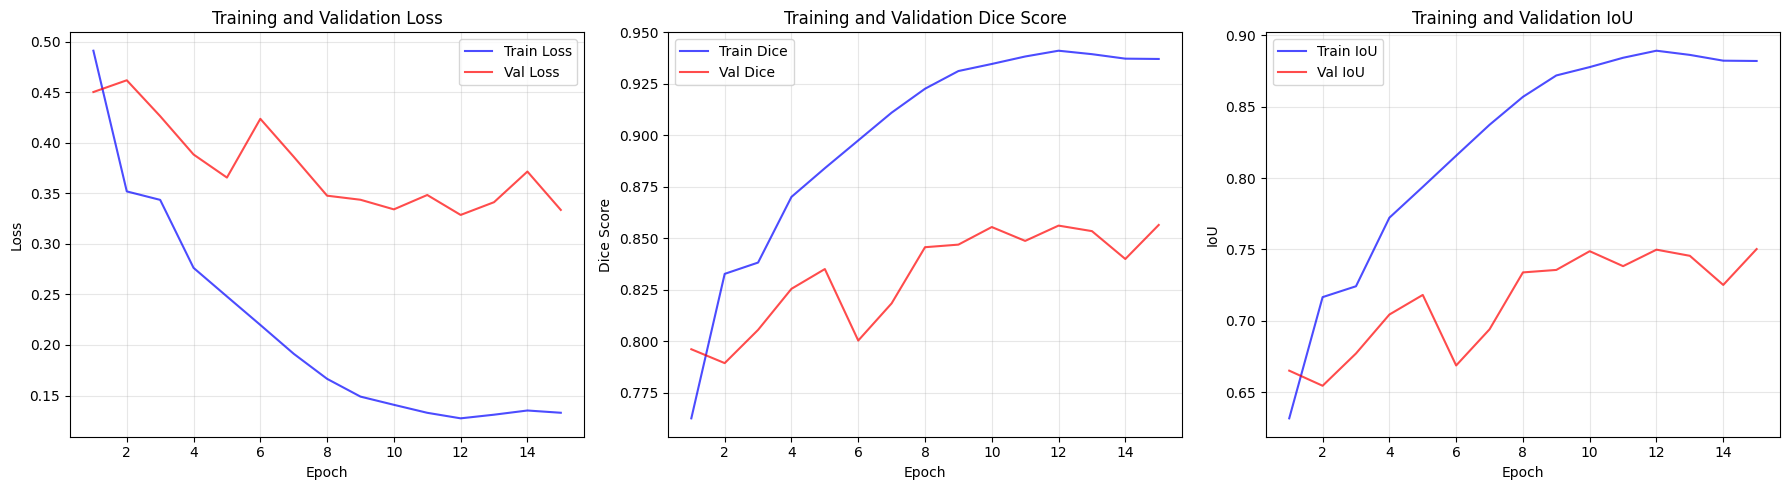


--- Testowanie najlepszego modelu z etapu 2 ---
Nie znaleziono zapisanego modelu po fine-tuningu, używanie ostatnio wytrenowanego modelu...
Wyniki testowania modelu po fine-tuningu:
Train: 700 | Val: 200 | Test: 100
Testing DataLoader 0: 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_dice           0.8943719267845154
        test_iou            0.8095591068267822
        test_loss           0.21311631798744202
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Wizualizacja predykcji dla etapu 2 ---


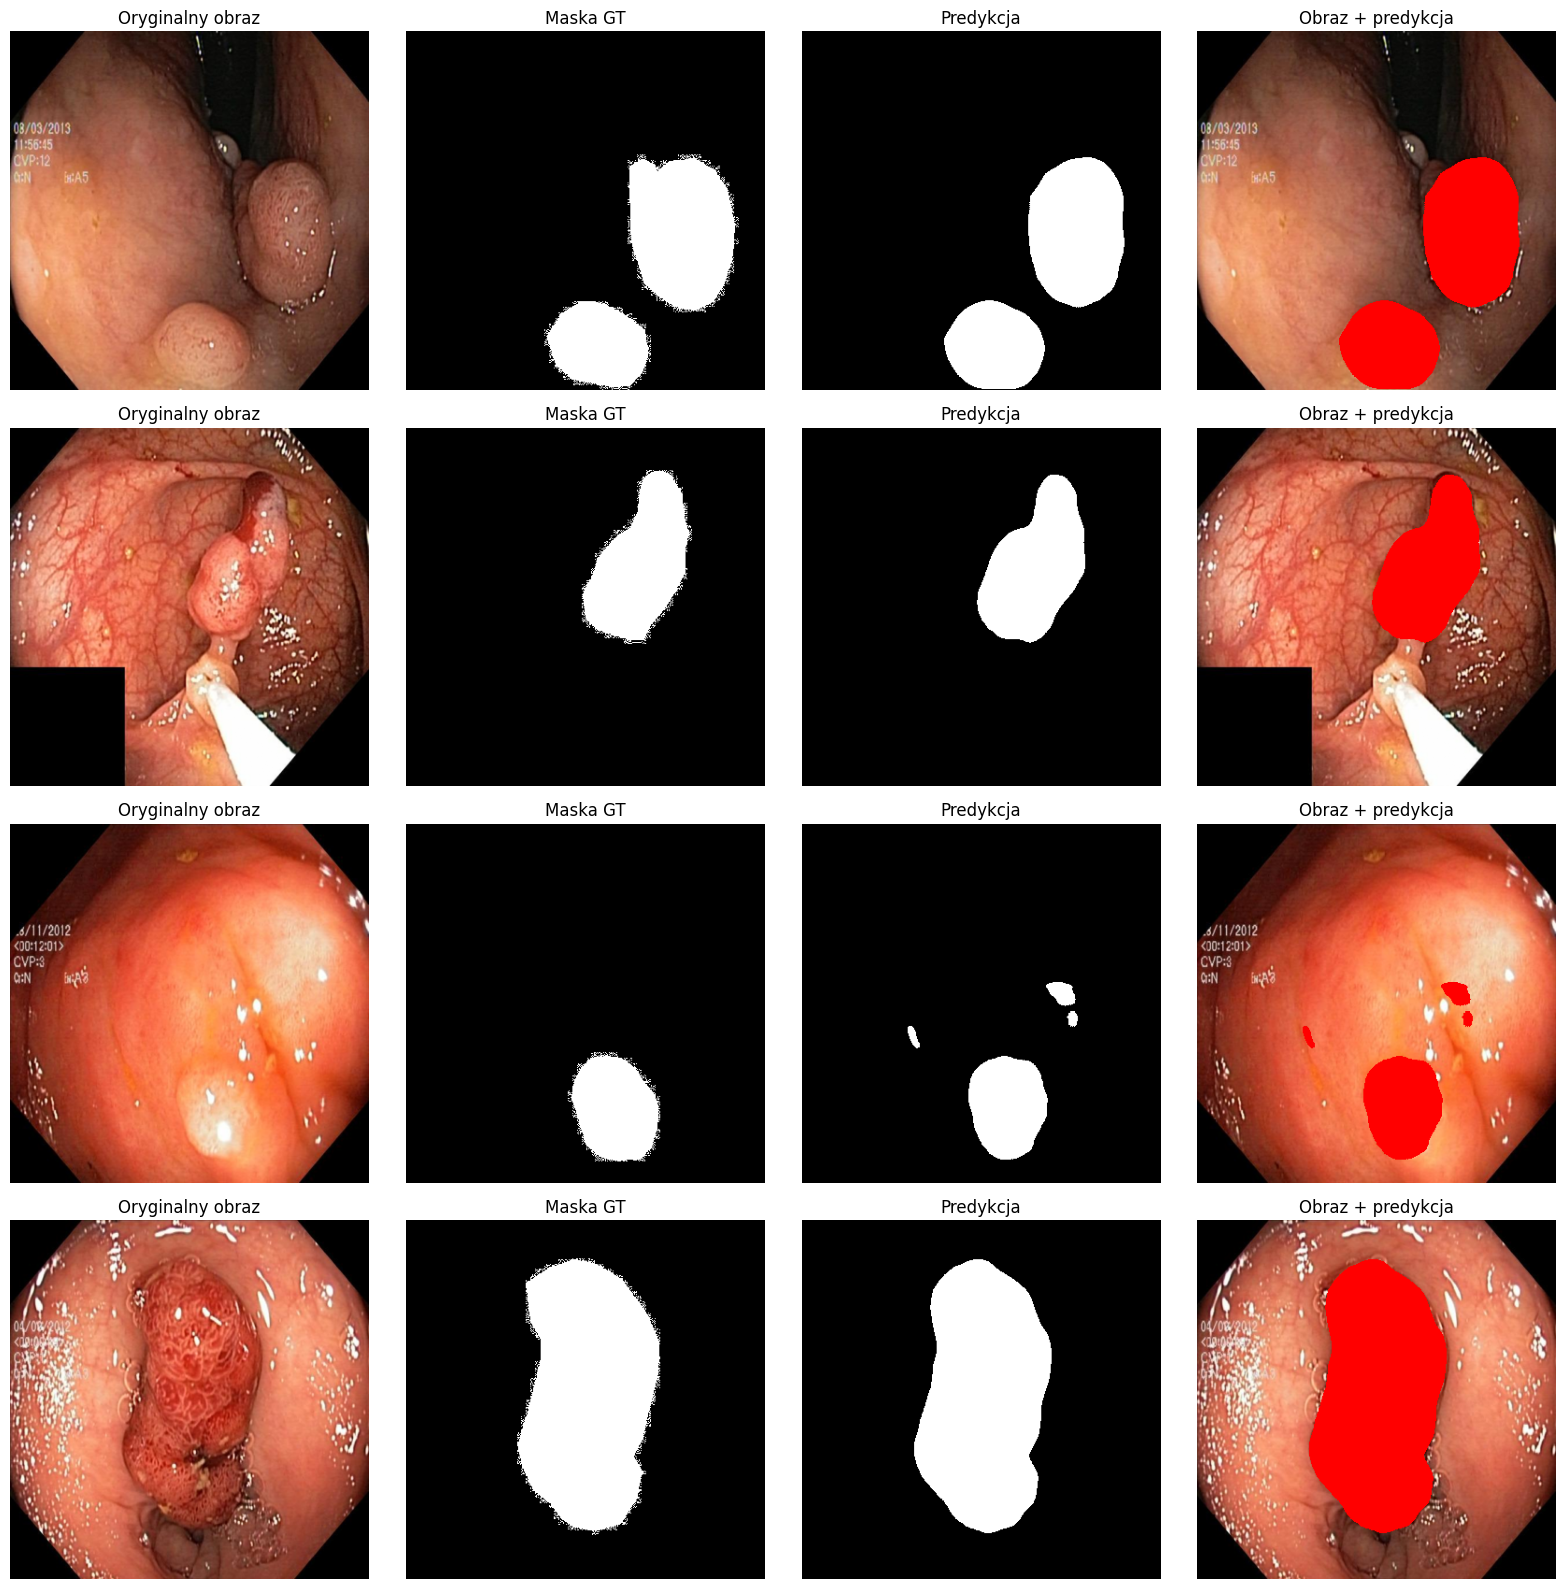


=== PORÓWNANIE WYNIKÓW ===
Obliczanie metryk dla modelu z zamrożonym enkoderem...
Obliczanie metryk dla modelu po fine-tuningu...

PORÓWNANIE KOŃCOWE
Metryka         Frozen Encoder  Fine-tuned      Różnica   
--------------- --------------- --------------- ----------
IoU             0.8201          0.8201          +0.0000
Dice/F1         0.9005          0.9005          +0.0000
Finalne modele zapisane w folderze './final_models/'

--- Porównanie predykcji obu modeli ---


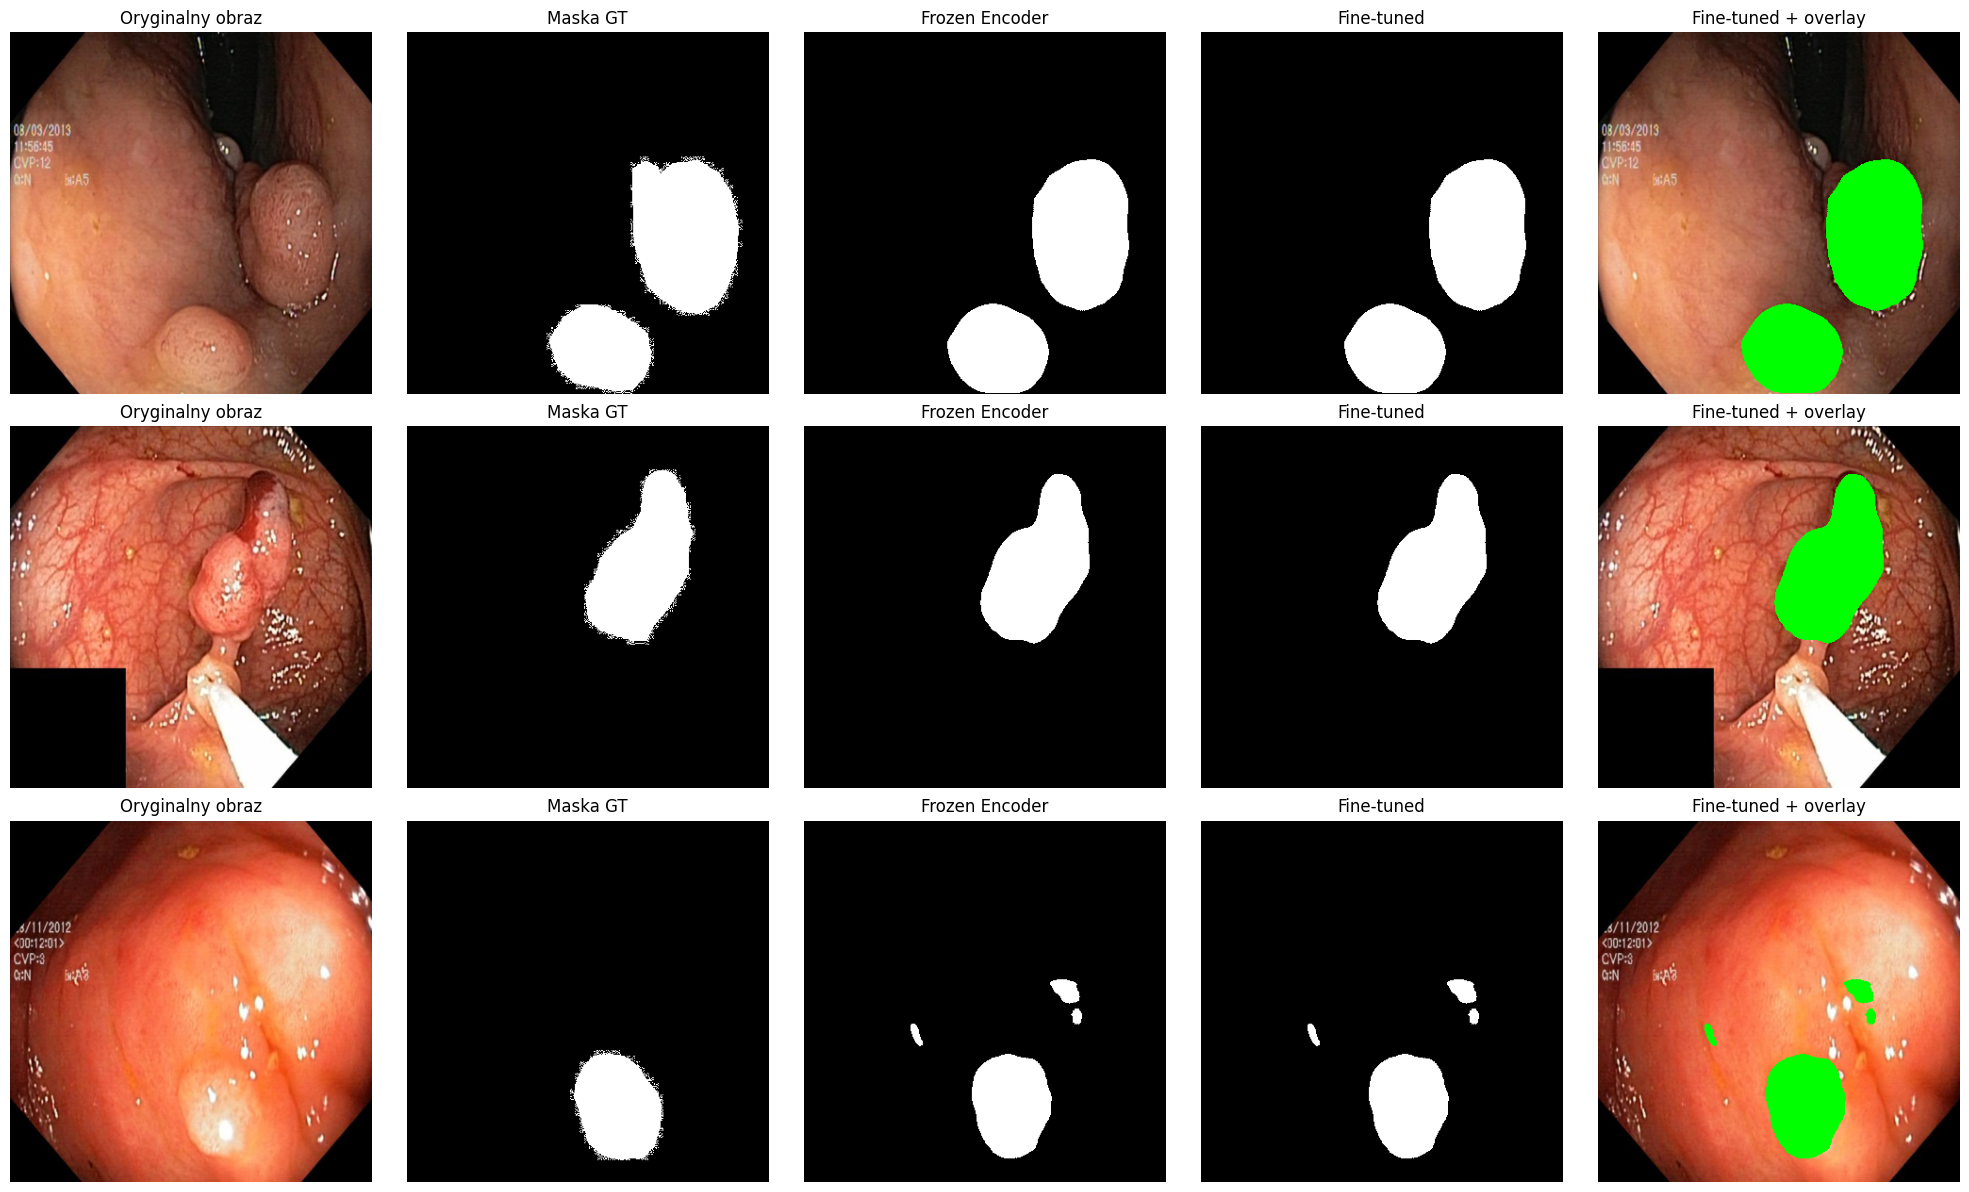


Dwuetapowy transfer learning zakończony pomyślnie!


In [ ]:
# 1. Tworzenie modelu z zamrożonym enkoderem
print("=== ETAP 1: Trening z zamrożonym enkoderem ===")

# Tworzenie modelu z zamrożonym enkoderem
model_frozen = LitUNetResNet(
    pretrained=True,
    freeze_encoder=True,  # Encoder zamrożony
    lr=1e-3,              # Wyższy learning rate dla dekodera
    dropout=0.2
)

# Callbacki
metrics_callback_frozen = MetricsCallback()

early_stopping_frozen = EarlyStopping(
    monitor='val_dice',
    patience=10,
    mode='max',
    verbose=True
)

checkpoint_callback_frozen = ModelCheckpoint(
    monitor='val_dice',
    dirpath='./checkpoints_frozen',
    filename='unet-resnet-frozen-{epoch:02d}-{val_dice:.3f}',
    save_top_k=1,
    mode='max',
    save_last=True
)

# Konfiguracja trenera dla etapu 1
trainer_frozen = Trainer(
    max_epochs=20,
    accelerator='auto',
    devices=1,
    callbacks=[metrics_callback_frozen, early_stopping_frozen, checkpoint_callback_frozen],
    precision=16,
    log_every_n_steps=10,
    enable_progress_bar=True
)

# Sprawdź czy istnieje checkpoint dla zamrożonego modelu
checkpoint_dir_frozen = Path('./checkpoints_frozen')
last_checkpoint_frozen = None

if checkpoint_dir_frozen.exists():
    checkpoint_files = list(checkpoint_dir_frozen.glob('*.ckpt'))
    if checkpoint_files:
        # Szukaj last.ckpt lub najnowszego checkpointu
        for checkpoint in checkpoint_files:
            if checkpoint.name == 'last.ckpt':
                last_checkpoint_frozen = str(checkpoint)
                break
        if not last_checkpoint_frozen and checkpoint_files:
            last_checkpoint_frozen = str(checkpoint_files[-1])

# Trening etapu 1
if last_checkpoint_frozen:
    print(f"Wznawianie treningu zamrożonego modelu z: {last_checkpoint_frozen}")
    trainer_frozen.fit(model_frozen, dm, ckpt_path=last_checkpoint_frozen)
else:
    print("Rozpoczynanie treningu zamrożonego modelu od początku")
    trainer_frozen.fit(model_frozen, dm)

print("Trening z zamrożonym enkoderem zakończony!")

# 2. Wizualizacja metryk dla etapu 1
print("\n--- Wizualizacja metryk dla etapu 1 (zamrożony encoder) ---")
plot_training_metrics(metrics_callback_frozen.metrics)

# 3. Testowanie najlepszego modelu z etapu 1
print("\n--- Testowanie najlepszego modelu z etapu 1 ---")

# Znajdź najlepszy checkpoint dla zamrożonego modelu
best_checkpoint_frozen = None
best_dice_frozen = -1

if checkpoint_dir_frozen.exists():
    checkpoint_files = list(checkpoint_dir_frozen.glob('*.ckpt'))
    for checkpoint in checkpoint_files:
        try:
            # Spróbuj wyciągnąć wartość dice z nazwy pliku
            dice_val = float(checkpoint.stem.split('-')[-1])
            if dice_val > best_dice_frozen:
                best_dice_frozen = dice_val
                best_checkpoint_frozen = checkpoint
        except (ValueError, IndexError):
            continue

if best_checkpoint_frozen:
    print(f"Ładowanie najlepszego zamrożonego modelu: {best_checkpoint_frozen} (Dice: {best_dice_frozen:.3f})")
    best_model_frozen = LitUNetResNet.load_from_checkpoint(str(best_checkpoint_frozen))
else:
    print("Nie znaleziono zapisanego zamrożonego modelu, używanie ostatnio wytrenowanego modelu...")
    best_model_frozen = model_frozen

best_model_frozen.eval()

# Testowanie na zbiorze testowym
print("Wyniki testowania zamrożonego modelu:")
trainer_frozen.test(best_model_frozen, dm)

# 4. Wizualizacja predykcji dla etapu 1
print("\n--- Wizualizacja predykcji dla etapu 1 ---")
xb_np_frozen, yb_np_frozen, preds_np_frozen, probs_np_frozen = visualize_predictions(
    best_model_frozen, dm, num_samples=4
)

# 5. Fine-tuning - odmrożenie enkodera i kontynuacja treningu
print("\n=== ETAP 2: Fine-tuning (odmrożony encoder) ===")

# Wczytaj najlepszy model z etapu 1 jako punkt wyjścia
if best_checkpoint_frozen:
    print("Wczytuję najlepszy model z etapu 1 jako bazę do fine-tuningu...")
    model_finetune = LitUNetResNet.load_from_checkpoint(str(best_checkpoint_frozen))
else:
    print("Używam ostatniego modelu z etapu 1 jako bazy do fine-tuningu...")
    model_finetune = model_frozen

# Odmrożenie enkodera
model_finetune.unfreeze_encoder()

# Zmniejszenie learning rate dla fine-tuningu
model_finetune.lr = 1e-4  # Niższy LR dla fine-tuningu
model_finetune.freeze_encoder_flag = False

# Callbacki dla fine-tuningu
metrics_callback_finetune = MetricsCallback()

early_stopping_finetune = EarlyStopping(
    monitor='val_dice',
    patience=8,  # Mniejsza cierpliwość dla fine-tuningu
    mode='max',
    verbose=True
)

checkpoint_callback_finetune = ModelCheckpoint(
    monitor='val_dice',
    dirpath='./checkpoints_finetune',
    filename='unet-resnet-finetune-{epoch:02d}-{val_dice:.3f}',
    save_top_k=1,
    mode='max',
    save_last=True
)

# Konfiguracja trenera dla etapu 2
trainer_finetune = Trainer(
    max_epochs=15,  # Krótszy trening dla fine-tuningu
    accelerator='auto',
    devices=1,
    callbacks=[metrics_callback_finetune, early_stopping_finetune, checkpoint_callback_finetune],
    precision=16,
    log_every_n_steps=10,
    enable_progress_bar=True
)

# Sprawdź czy istnieje checkpoint dla fine-tuningu
checkpoint_dir_finetune = Path('./checkpoints_finetune')
last_checkpoint_finetune = None

if checkpoint_dir_finetune.exists():
    checkpoint_files = list(checkpoint_dir_finetune.glob('*.ckpt'))
    if checkpoint_files:
        for checkpoint in checkpoint_files:
            if checkpoint.name == 'last.ckpt':
                last_checkpoint_finetune = str(checkpoint)
                break
        if not last_checkpoint_finetune and checkpoint_files:
            last_checkpoint_finetune = str(checkpoint_files[-1])

# Trening etapu 2 (fine-tuning)
if last_checkpoint_finetune:
    print(f"Wznawianie fine-tuningu z: {last_checkpoint_finetune}")
    trainer_finetune.fit(model_finetune, dm, ckpt_path=last_checkpoint_finetune)
else:
    print("Rozpoczynanie fine-tuningu od początku")
    trainer_finetune.fit(model_finetune, dm)

print("Fine-tuning zakończony!")

# 6. Wizualizacja metryk dla etapu 2
print("\n--- Wizualizacja metryk dla etapu 2 (fine-tuning) ---")
plot_training_metrics(metrics_callback_finetune.metrics)

# 7. Testowanie najlepszego modelu z etapu 2
print("\n--- Testowanie najlepszego modelu z etapu 2 ---")

# Znajdź najlepszy checkpoint dla fine-tuningu
best_checkpoint_finetune = None
best_dice_finetune = -1

if checkpoint_dir_finetune.exists():
    checkpoint_files = list(checkpoint_dir_finetune.glob('*.ckpt'))
    for checkpoint in checkpoint_files:
        try:
            dice_val = float(checkpoint.stem.split('-')[-1])
            if dice_val > best_dice_finetune:
                best_dice_finetune = dice_val
                best_checkpoint_finetune = checkpoint
        except (ValueError, IndexError):
            continue

if best_checkpoint_finetune:
    print(f"Ładowanie najlepszego modelu po fine-tuningu: {best_checkpoint_finetune} (Dice: {best_dice_finetune:.3f})")
    best_model_finetune = LitUNetResNet.load_from_checkpoint(str(best_checkpoint_finetune))
else:
    print("Nie znaleziono zapisanego modelu po fine-tuningu, używanie ostatnio wytrenowanego modelu...")
    best_model_finetune = model_finetune

best_model_finetune.eval()

# Testowanie na zbiorze testowym
print("Wyniki testowania modelu po fine-tuningu:")
trainer_finetune.test(best_model_finetune, dm)

# 8. Wizualizacja predykcji dla etapu 2
print("\n--- Wizualizacja predykcji dla etapu 2 ---")
xb_np_finetune, yb_np_finetune, preds_np_finetune, probs_np_finetune = visualize_predictions(
    best_model_finetune, dm, num_samples=4
)

# 9. Porównanie wyników obu etapów
print("\n=== PORÓWNANIE WYNIKÓW ===")

def calculate_comprehensive_metrics(model, datamodule, num_batches=10):
    """Oblicza kompleksowe metryki na kilku batchach"""
    model.eval()
    test_loader = datamodule.test_dataloader()
    
    total_iou = 0
    total_dice = 0
    total_batches = 0
    
    with torch.no_grad():
        for i, (xb, yb) in enumerate(test_loader):
            if i >= num_batches:
                break
                
            logits = model(xb)
            preds = (torch.sigmoid(logits) > 0.5).int()
            y_int = yb.int()
            
            # Oblicz metryki dla batcha
            iou_metric = BinaryJaccardIndex()
            dice_metric = BinaryF1Score()
            
            batch_iou = iou_metric(preds, y_int)
            batch_dice = dice_metric(preds, y_int)
            
            total_iou += batch_iou
            total_dice += batch_dice
            total_batches += 1
    
    avg_iou = total_iou / total_batches if total_batches > 0 else 0
    avg_dice = total_dice / total_batches if total_batches > 0 else 0
    
    return avg_iou.item(), avg_dice.item()

# Oblicz metryki dla obu modeli
print("Obliczanie metryk dla modelu z zamrożonym enkoderem...")
iou_frozen, dice_frozen = calculate_comprehensive_metrics(best_model_frozen, dm)

print("Obliczanie metryk dla modelu po fine-tuningu...")
iou_finetune, dice_finetune = calculate_comprehensive_metrics(best_model_finetune, dm)

# Wyświetl porównanie
print("\n" + "="*50)
print("PORÓWNANIE KOŃCOWE")
print("="*50)
print(f"{'Metryka':<15} {'Frozen Encoder':<15} {'Fine-tuned':<15} {'Różnica':<10}")
print(f"{'-'*15} {'-'*15} {'-'*15} {'-'*10}")
print(f"{'IoU':<15} {iou_frozen:.4f}{'':<9} {iou_finetune:.4f}{'':<9} {iou_finetune - iou_frozen:+.4f}")
print(f"{'Dice/F1':<15} {dice_frozen:.4f}{'':<9} {dice_finetune:.4f}{'':<9} {dice_finetune - dice_frozen:+.4f}")
print("="*50)

# 10. Zapisanie finalnych modeli
def save_final_models(frozen_model, finetune_model):
    """Zapisuje finalne wagi modeli"""
    # Utwórz katalog jeśli nie istnieje
    Path('./final_models').mkdir(exist_ok=True)
    
    # Zapisz wagi
    torch.save(frozen_model.model.state_dict(), './final_models/unet_resnet_frozen.pth')
    torch.save(finetune_model.model.state_dict(), './final_models/unet_resnet_finetune.pth')
    
    print("Finalne modele zapisane w folderze './final_models/'")

save_final_models(best_model_frozen, best_model_finetune)

# 11. Dodatkowa wizualizacja - porównanie obu modeli na tych samych przykładach
def compare_models_on_same_examples(frozen_model, finetune_model, datamodule, num_samples=3):
    """Porównuje predykcje obu modeli na tych samych przykładach"""
    frozen_model.eval()
    finetune_model.eval()
    
    # Pobierz batch testowy
    test_loader = datamodule.test_dataloader()
    xb, yb = next(iter(test_loader))
    
    # Predykcje
    with torch.no_grad():
        logits_frozen = frozen_model(xb)
        preds_frozen = (torch.sigmoid(logits_frozen) > 0.5).int()
        
        logits_finetune = finetune_model(xb)
        preds_finetune = (torch.sigmoid(logits_finetune) > 0.5).int()
    
    # Konwersja do numpy
    xb_np = xb.cpu().numpy()
    yb_np = yb.cpu().numpy()
    preds_frozen_np = preds_frozen.cpu().numpy()
    preds_finetune_np = preds_finetune.cpu().numpy()
    
    # Wizualizacja
    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4 * num_samples))
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        # Oryginalny obraz
        img = ((xb_np[i].transpose(1, 2, 0) * 0.5) + 0.5).clip(0, 1)
        
        # Maska GT
        gt_mask = yb_np[i, 0]
        
        # Predykcje
        pred_frozen = preds_frozen_np[i, 0]
        pred_finetune = preds_finetune_np[i, 0]
        
        # Overlay
        overlay_frozen = img.copy()
        overlay_finetune = img.copy()
        
        mask_frozen = preds_frozen_np[i, 0] > 0.5
        mask_finetune = preds_finetune_np[i, 0] > 0.5
        
        overlay_frozen[mask_frozen] = [1.0, 0.0, 0.0]  # Czerwony
        overlay_finetune[mask_finetune] = [0.0, 1.0, 0.0]  # Zielony
        
        # Wyświetlanie
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Oryginalny obraz')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(gt_mask, cmap='gray')
        axes[i, 1].set_title('Maska GT')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_frozen, cmap='gray')
        axes[i, 2].set_title('Frozen Encoder')
        axes[i, 2].axis('off')
        
        axes[i, 3].imshow(pred_finetune, cmap='gray')
        axes[i, 3].set_title('Fine-tuned')
        axes[i, 3].axis('off')
        
        axes[i, 4].imshow(overlay_finetune)
        axes[i, 4].set_title('Fine-tuned + overlay')
        axes[i, 4].axis('off')
    
    plt.tight_layout()
    plt.show()

print("\n--- Porównanie predykcji obu modeli ---")
compare_models_on_same_examples(best_model_frozen, best_model_finetune, dm, num_samples=3)

print("\nDwuetapowy transfer learning zakończony pomyślnie!")

## Zadanie 6 – Dwuetapowy Transfer Learning: Fine-tuning

**Fine-tuning całej sieci:**
1. Odmroź encoder dla najlepszego modelu z poporzedniej części.
2. Ustaw learning rate: `best_stage1.hparams.lr = ` (podczas fine-tuningu zazwyczaj jest mniejszy).
3. Zaktualizuj hparam: `best_stage1.hparams.freeze_encoder = False`.
4. Stwórz nowe callbacki: `MetricsCallback`, `EarlyStopping`, `ModelCheckpoint`.
5. Stwórz nowy `Trainer`.
6. Wykonaj trening wywołując metodę `fit`.
7. Sprawdź oraz wyświetl metryki (3 wykresy: loss, dice, iou) podobnie jak we wcześniejszym treningu.
8. Wczytaj najlepszy model sieci i wykonaj dla niego testy na zbiorze testowym.
9. Wyświetl przykładowe predykcje (4 obrazy × 4 kolumny).

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params | Mode
--------------------------------------------------------
0 | model     | UNetResNet         | 14.3 M | eval
1 | bce_loss  | BCEWithLogitsLoss  | 0      | eval
2 | dice_loss | DiceLoss           | 0      | eval
3 | train_iou | BinaryJaccardIndex | 0      | eval
4 | val_iou   | BinaryJaccardIndex | 0      | eval
5 | test_iou  | BinaryJaccardIndex | 0      | eval
6 | train_f1  | BinaryF1Score      | 0      | eval
7 | val_f1    | BinaryF1Score      | 0      | eval
8 | test_f1   | BinaryF1Score      | 0      | eval
--------------------------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.378    Total estimated model params size (MB)
0         Modules in train mode
131       Modules in eval mode


=== ZADANIE 6: FINE-TUNING CAŁEJ SIECI ===

1. Wczytywanie najlepszego modelu z etapu 1 i odmrażanie enkodera...
Używam ostatniego modelu z etapu 1...

2. Odmrażanie enkodera i konfiguracja fine-tuningu...
Encoder odmrożony - cała sieć będzie trenowana
Learning rate zmieniony z 0.0001 na 1e-05
Encoder odmrożony: True

3. Aktualizacja hiperparametrów...

4. Tworzenie callbacków dla fine-tuningu...
Callbacki utworzone:
 - EarlyStopping: patience=8, monitor='val_dice'
 - ModelCheckpoint: zapis w './checkpoints_finetune_task6/'

5. Konfiguracja Trainera dla fine-tuningu...
Trainer skonfigurowany: max_epochs=15, precision=16

6. Rozpoczynanie fine-tuningu...
Rozpoczynanie fine-tuningu od początku
Train: 700 | Val: 200 | Test: 100
Epoch 0: 100%|██████████| 44/44 [01:31<00:00,  0.48it/s, v_num=9, train_loss_step=0.162, train_dice_step=0.931, train_iou_step=0.870, val_loss=0.165, val_dice=0.923, val_iou=0.858, train_loss_epoch=0.180, train_dice_epoch=0.917, train_iou_epoch=0.848]

Metric val_dice improved. New best score: 0.923


Epoch 1: 100%|██████████| 44/44 [01:35<00:00,  0.46it/s, v_num=9, train_loss_step=0.136, train_dice_step=0.941, train_iou_step=0.888, val_loss=0.163, val_dice=0.925, val_iou=0.862, train_loss_epoch=0.163, train_dice_epoch=0.926, train_iou_epoch=0.862] 

Metric val_dice improved by 0.002 >= min_delta = 0.0. New best score: 0.925


Epoch 3: 100%|██████████| 44/44 [01:35<00:00,  0.46it/s, v_num=9, train_loss_step=0.135, train_dice_step=0.942, train_iou_step=0.890, val_loss=0.161, val_dice=0.925, val_iou=0.862, train_loss_epoch=0.141, train_dice_epoch=0.935, train_iou_epoch=0.879] 

Metric val_dice improved by 0.000 >= min_delta = 0.0. New best score: 0.925


Epoch 4: 100%|██████████| 44/44 [01:36<00:00,  0.46it/s, v_num=9, train_loss_step=0.147, train_dice_step=0.930, train_iou_step=0.869, val_loss=0.161, val_dice=0.926, val_iou=0.863, train_loss_epoch=0.131, train_dice_epoch=0.939, train_iou_epoch=0.886] 

Metric val_dice improved by 0.001 >= min_delta = 0.0. New best score: 0.926


Epoch 6: 100%|██████████| 44/44 [01:35<00:00,  0.46it/s, v_num=9, train_loss_step=0.153, train_dice_step=0.919, train_iou_step=0.850, val_loss=0.161, val_dice=0.926, val_iou=0.863, train_loss_epoch=0.128, train_dice_epoch=0.940, train_iou_epoch=0.888] 

Metric val_dice improved by 0.000 >= min_delta = 0.0. New best score: 0.926


Epoch 14: 100%|██████████| 44/44 [01:35<00:00,  0.46it/s, v_num=9, train_loss_step=0.0753, train_dice_step=0.965, train_iou_step=0.932, val_loss=0.167, val_dice=0.924, val_iou=0.860, train_loss_epoch=0.0968, train_dice_epoch=0.954, train_iou_epoch=0.912]

Monitored metric val_dice did not improve in the last 8 records. Best score: 0.926. Signaling Trainer to stop.
`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 44/44 [01:36<00:00,  0.46it/s, v_num=9, train_loss_step=0.0753, train_dice_step=0.965, train_iou_step=0.932, val_loss=0.167, val_dice=0.924, val_iou=0.860, train_loss_epoch=0.0968, train_dice_epoch=0.954, train_iou_epoch=0.912]
Fine-tuning zakończony!

7. Wizualizacja metryk fine-tuningu...


ValueError: x and y must have same first dimension, but have shapes (15,) and (16,)

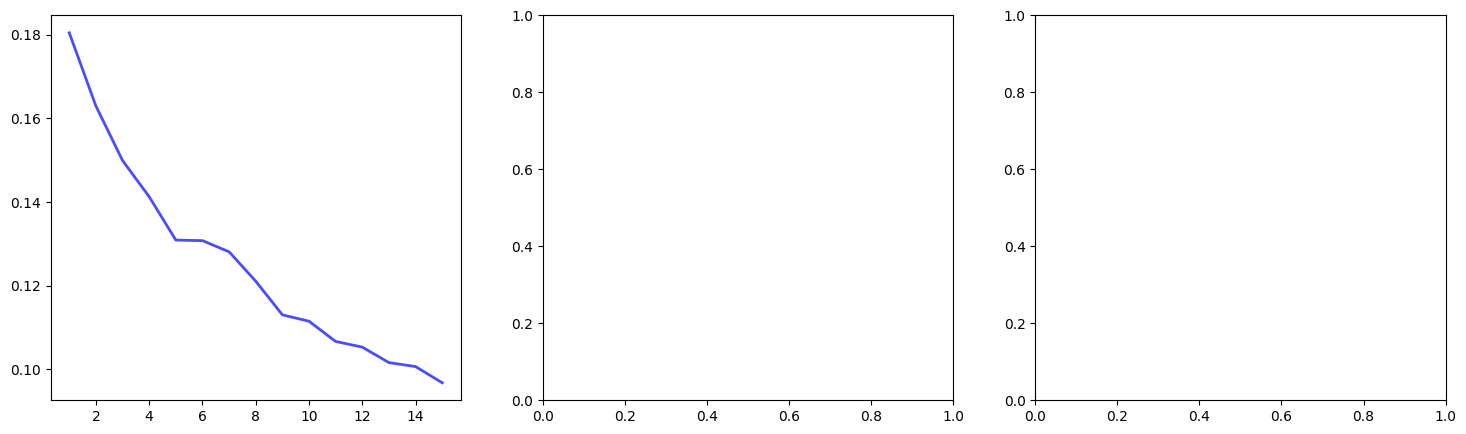

In [ ]:
# Zadanie 6 – Dwuetapowy Transfer Learning: Fine-tuning

print("=== ZADANIE 6: FINE-TUNING CAŁEJ SIECI ===")

# 1. Wczytanie najlepszego modelu z etapu 1 i odmrożenie enkodera
print("\n1. Wczytywanie najlepszego modelu z etapu 1 i odmrażanie enkodera...")

if 'best_checkpoint_frozen' in locals() and best_checkpoint_frozen:
    print(f"Wczytuję model z: {best_checkpoint_frozen}")
    model_finetune = LitUNetResNet.load_from_checkpoint(str(best_checkpoint_frozen))
else:
    # Jeśli nie mamy zapisanego checkpointu, użyjmy ostatniego modelu z etapu 1
    print("Używam ostatniego modelu z etapu 1...")
    model_finetune = model_frozen

# 2. Odmrożenie enkodera i ustawienie mniejszego learning rate
print("\n2. Odmrażanie enkodera i konfiguracja fine-tuningu...")

# Odmrożenie enkodera
model_finetune.unfreeze_encoder()

# Ustawienie mniejszego learning rate dla fine-tuningu
original_lr = model_finetune.lr
new_lr = original_lr * 0.1  # 10x mniejszy LR
model_finetune.lr = new_lr
model_finetune.freeze_encoder_flag = False

print(f"Learning rate zmieniony z {original_lr} na {new_lr}")
print(f"Encoder odmrożony: {not model_finetune.freeze_encoder_flag}")

# 3. Aktualizacja hiperparametrów
print("\n3. Aktualizacja hiperparametrów...")
model_finetune.hparams.freeze_encoder = False
model_finetune.hparams.lr = new_lr

# 4. Tworzenie nowych callbacków dla fine-tuningu
print("\n4. Tworzenie callbacków dla fine-tuningu...")

metrics_callback_finetune = MetricsCallback()

early_stopping_finetune = EarlyStopping(
    monitor='val_dice',
    patience=8,  # Mniejsza cierpliwość dla fine-tuningu
    mode='max',
    verbose=True
)

checkpoint_callback_finetune = ModelCheckpoint(
    monitor='val_dice',
    dirpath='./checkpoints_finetune_task6',
    filename='unet-resnet-finetune-{epoch:02d}-{val_dice:.3f}',
    save_top_k=1,
    mode='max',
    save_last=True,
    every_n_epochs=1
)

print("Callbacki utworzone:")
print(f" - EarlyStopping: patience=8, monitor='val_dice'")
print(f" - ModelCheckpoint: zapis w './checkpoints_finetune_task6/'")

# 5. Tworzenie nowego Trainera dla fine-tuningu
print("\n5. Konfiguracja Trainera dla fine-tuningu...")

trainer_finetune = Trainer(
    max_epochs=15,  # Krótszy trening dla fine-tuningu
    accelerator='auto',
    devices=1,
    callbacks=[metrics_callback_finetune, early_stopping_finetune, checkpoint_callback_finetune],
    precision=16,
    log_every_n_steps=5,
    enable_progress_bar=True
)

print(f"Trainer skonfigurowany: max_epochs=15, precision=16")

# 6. Wykonanie treningu fine-tuningu
print("\n6. Rozpoczynanie fine-tuningu...")

# Sprawdź czy istnieje checkpoint dla fine-tuningu
checkpoint_dir_finetune = Path('./checkpoints_finetune_task6')
last_checkpoint_finetune = None

if checkpoint_dir_finetune.exists():
    checkpoint_files = list(checkpoint_dir_finetune.glob('*.ckpt'))
    if checkpoint_files:
        for checkpoint in checkpoint_files:
            if checkpoint.name == 'last.ckpt':
                last_checkpoint_finetune = str(checkpoint)
                break
        if not last_checkpoint_finetune and checkpoint_files:
            last_checkpoint_finetune = str(checkpoint_files[-1])

if last_checkpoint_finetune:
    print(f"Wznawianie fine-tuningu z checkpointu: {last_checkpoint_finetune}")
    trainer_finetune.fit(model_finetune, dm, ckpt_path=last_checkpoint_finetune)
else:
    print("Rozpoczynanie fine-tuningu od początku")
    trainer_finetune.fit(model_finetune, dm)

print("Fine-tuning zakończony!")


7. Wizualizacja metryk fine-tuningu...


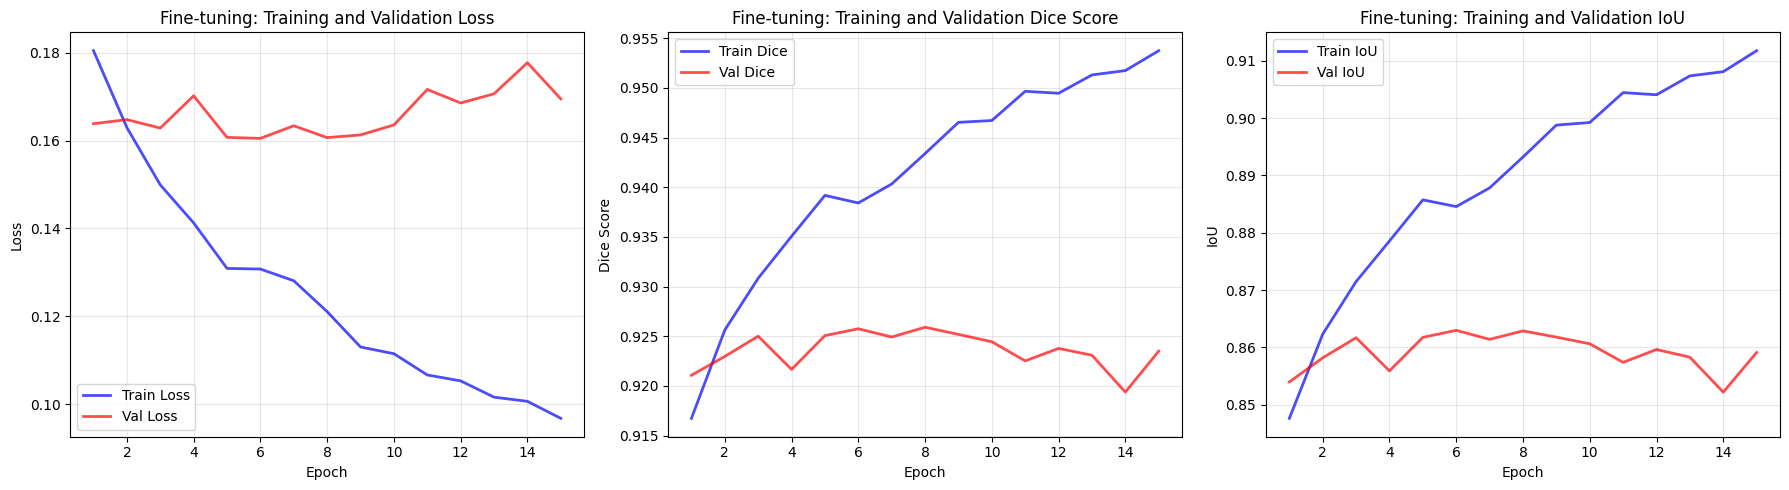

Długości list - Epoch: 15, Train Loss: 15, Val Loss: 16

8. Testowanie najlepszego modelu po fine-tuningu...
Nie znaleziono zapisanego modelu po fine-tuningu, używanie ostatnio wytrenowanego modelu...

Wyniki testowania modelu po fine-tuningu:
Train: 700 | Val: 200 | Test: 100
Testing DataLoader 0: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_dice            0.947552502155304
        test_iou             0.900526762008667
        test_loss           0.1158384308218956
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

9. Szczegółowa analiza wyników...
Przeprowadzam szczegółową analizę na zbiorze testowym...
Analiza na 80 

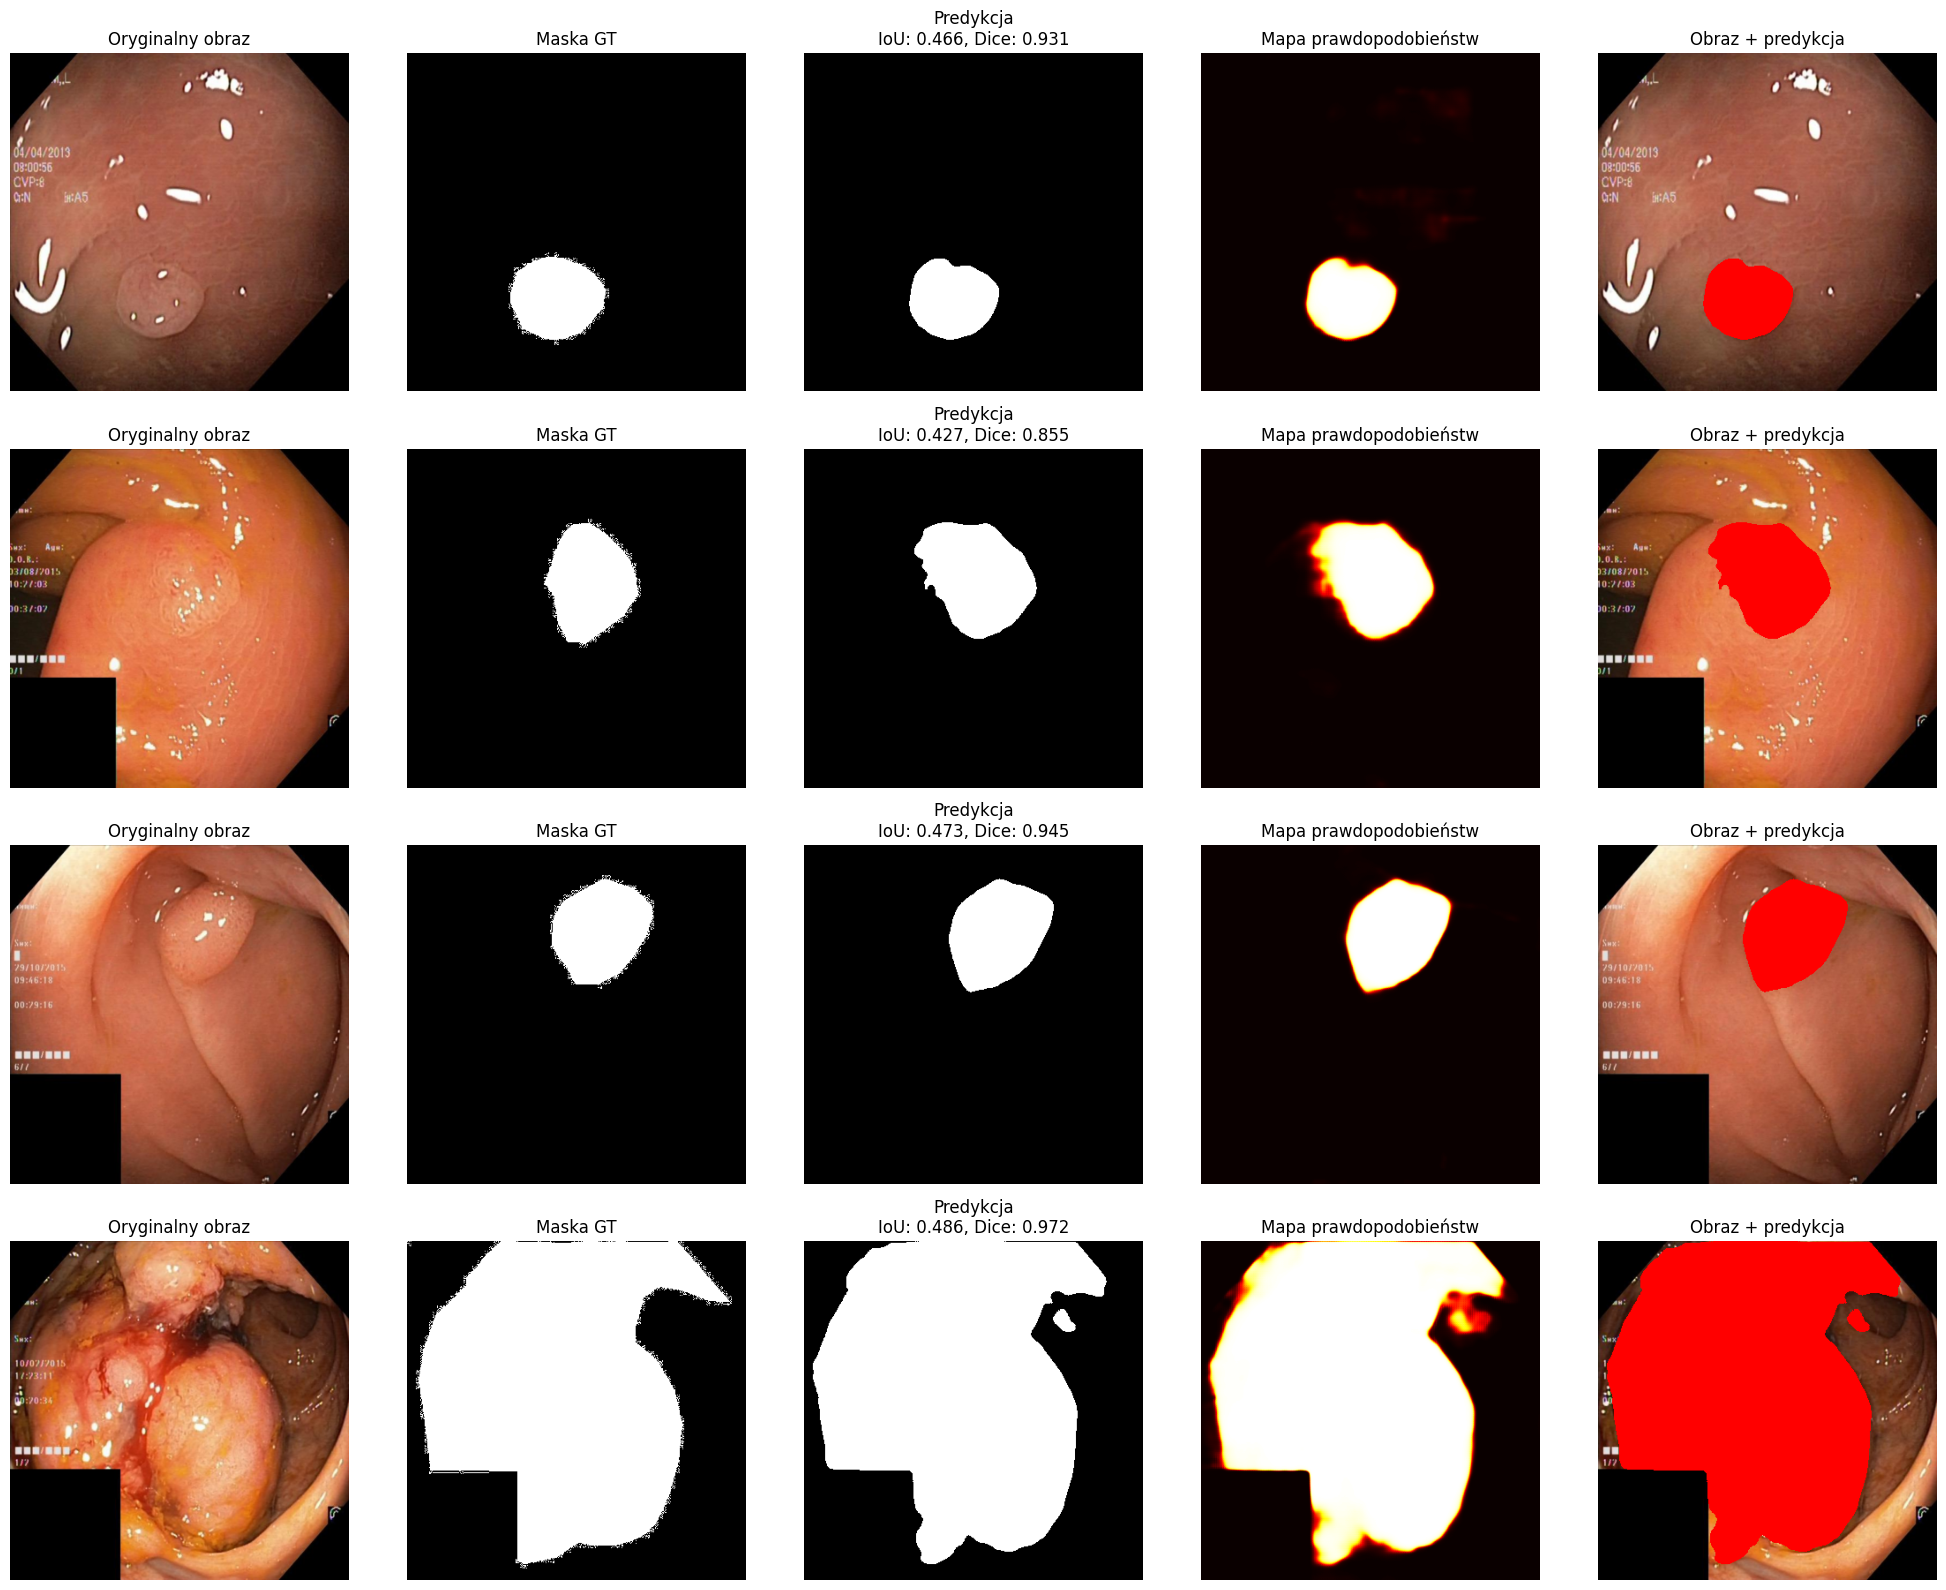


11. Porównanie z modelem przed fine-tuningiem...
Testowanie modelu przed fine-tuningiem dla porównania...
Train: 700 | Val: 200 | Test: 100
Testing DataLoader 0: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_dice           0.9543663859367371
        test_iou            0.9127739071846008
        test_loss           0.09296659380197525
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Porównanie parametrów:
Model przed fine-tuningiem: 14,344,513 / 14,344,513 parametrów uczonych
Model po fine-tuningu: 14,344,513 / 14,344,513 parametrów uczonych
Różnica: 0 dodatkowych parametrów uczonych

12. Zapisanie finalnego modelu...
F

In [ ]:

# 7. Wizualizacja metryk dla fine-tuningu
print("\n7. Wizualizacja metryk fine-tuningu...")

def plot_finetune_metrics(metrics):
    """Specjalna wizualizacja dla fine-tuningu z naprawionym błędem długości list"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Upewnij się, że długości list są zgodne
    train_epochs = metrics['epoch']
    
    # Loss - dopasuj długości list
    axes[0].plot(train_epochs, metrics['train_loss'], 'b-', label='Train Loss', alpha=0.7, linewidth=2)
    if metrics['val_loss']:
        # Przycięcie do minimalnej długości
        min_len = min(len(train_epochs), len(metrics['val_loss']))
        axes[0].plot(train_epochs[:min_len], metrics['val_loss'][:min_len], 'r-', label='Val Loss', alpha=0.7, linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Fine-tuning: Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Dice/F1 Score
    axes[1].plot(train_epochs, metrics['train_dice'], 'b-', label='Train Dice', alpha=0.7, linewidth=2)
    if metrics['val_dice']:
        min_len = min(len(train_epochs), len(metrics['val_dice']))
        axes[1].plot(train_epochs[:min_len], metrics['val_dice'][:min_len], 'r-', label='Val Dice', alpha=0.7, linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice Score')
    axes[1].set_title('Fine-tuning: Training and Validation Dice Score')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # IoU
    axes[2].plot(train_epochs, metrics['train_iou'], 'b-', label='Train IoU', alpha=0.7, linewidth=2)
    if metrics['val_iou']:
        min_len = min(len(train_epochs), len(metrics['val_iou']))
        axes[2].plot(train_epochs[:min_len], metrics['val_iou'][:min_len], 'r-', label='Val IoU', alpha=0.7, linewidth=2)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('IoU')
    axes[2].set_title('Fine-tuning: Training and Validation IoU')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Debug: wyświetl długości list
    print(f"Długości list - Epoch: {len(metrics['epoch'])}, Train Loss: {len(metrics['train_loss'])}, Val Loss: {len(metrics['val_loss']) if metrics['val_loss'] else 0}")

# Wywołanie naprawionej wizualizacji
plot_finetune_metrics(metrics_callback_finetune.metrics)

# 8. Wczytanie najlepszego modelu po fine-tuningu i testowanie
print("\n8. Testowanie najlepszego modelu po fine-tuningu...")

# Znajdź najlepszy checkpoint dla fine-tuningu
best_checkpoint_finetune_task6 = None
best_dice_finetune_task6 = -1

if checkpoint_dir_finetune.exists():
    checkpoint_files = list(checkpoint_dir_finetune.glob('*.ckpt'))
    for checkpoint in checkpoint_files:
        try:
            dice_val = float(checkpoint.stem.split('-')[-1])
            if dice_val > best_dice_finetune_task6:
                best_dice_finetune_task6 = dice_val
                best_checkpoint_finetune_task6 = checkpoint
        except (ValueError, IndexError):
            continue

if best_checkpoint_finetune_task6:
    print(f"Ładowanie najlepszego modelu po fine-tuningu: {best_checkpoint_finetune_task6}")
    print(f"Val Dice: {best_dice_finetune_task6:.3f}")
    best_model_finetune_task6 = LitUNetResNet.load_from_checkpoint(str(best_checkpoint_finetune_task6))
else:
    print("Nie znaleziono zapisanego modelu po fine-tuningu, używanie ostatnio wytrenowanego modelu...")
    best_model_finetune_task6 = model_finetune

best_model_finetune_task6.eval()

# Testowanie na zbiorze testowym
print("\nWyniki testowania modelu po fine-tuningu:")
test_results = trainer_finetune.test(best_model_finetune_task6, dm)

# 9. Szczegółowa analiza wyników testowych
print("\n9. Szczegółowa analiza wyników...")

def detailed_test_analysis(model, datamodule, num_batches=5):
    """Przeprowadza szczegółową analizę na zbiorze testowym"""
    model.eval()
    test_loader = datamodule.test_dataloader()
    
    all_ious = []
    all_dices = []
    
    with torch.no_grad():
        for i, (xb, yb) in enumerate(test_loader):
            if i >= num_batches:
                break
                
            logits = model(xb)
            preds = (torch.sigmoid(logits) > 0.5).int()
            y_int = yb.int()
            
            # Oblicz metryki dla każdego obrazu w batchu
            batch_size = xb.size(0)
            for j in range(batch_size):
                # IoU dla pojedynczego obrazu
                intersection = (preds[j] & y_int[j]).float().sum()
                union = (preds[j] | y_int[j]).float().sum()
                iou = (intersection + 1e-6) / (union + 1e-6)
                
                # Dice dla pojedynczego obrazu
                dice = (2. * intersection + 1e-6) / (preds[j].float().sum() + y_int[j].float().sum() + 1e-6)
                
                all_ious.append(iou.item())
                all_dices.append(dice.item())
    
    return all_ious, all_dices

# Przeprowadź szczegółową analizę
print("Przeprowadzam szczegółową analizę na zbiorze testowym...")
ious_detailed, dices_detailed = detailed_test_analysis(best_model_finetune_task6, dm)

print(f"Analiza na {len(ious_detailed)} przykładach testowych:")
print(f"IoU - Średnia: {np.mean(ious_detailed):.4f} ± {np.std(ious_detailed):.4f}")
print(f"IoU - Mediana: {np.median(ious_detailed):.4f}")
print(f"IoU - Min: {np.min(ious_detailed):.4f}, Max: {np.max(ious_detailed):.4f}")
print(f"Dice - Średnia: {np.mean(dices_detailed):.4f} ± {np.std(dices_detailed):.4f}")
print(f"Dice - Mediana: {np.median(dices_detailed):.4f}")
print(f"Dice - Min: {np.min(dices_detailed):.4f}, Max: {np.max(dices_detailed):.4f}")

# 10. Wizualizacja predykcji po fine-tuningu
print("\n10. Wizualizacja predykcji po fine-tuningu...")

def visualize_finetune_predictions(model, datamodule, num_samples=4):
    """Rozszerzona wizualizacja predykcji z dodatkowymi informacjami"""
    model.eval()
    
    # Pobranie batcha testowego
    test_loader = datamodule.test_dataloader()
    xb, yb = next(iter(test_loader))
    
    # Predykcje z prawdopodobieństwami
    with torch.no_grad():
        logits = model(xb)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).int()
    
    # Konwersja tensorów do numpy
    xb_np = xb.cpu().numpy()
    yb_np = yb.cpu().numpy()
    preds_np = preds.cpu().numpy()
    probs_np = probs.cpu().numpy()
    
    # Wizualizacja z metrykami dla każdego przykładu
    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4 * num_samples))
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        # Oryginalny obraz (denormalizacja)
        img = ((xb_np[i].transpose(1, 2, 0) * 0.5) + 0.5).clip(0, 1)
        
        # Maska GT
        gt_mask = yb_np[i, 0]
        
        # Predykcja
        pred_mask = preds_np[i, 0]
        
        # Map prawdopodobieństw
        prob_map = probs_np[i, 0]
        
        # Obraz z nałożoną predykcją
        overlay = img.copy()
        mask_pred = preds_np[i, 0] > 0.5
        overlay[mask_pred] = [1.0, 0.0, 0.0]  # Czerwony kolor dla predykcji
        
        # Oblicz metryki dla tego przykładu
        intersection = (pred_mask * gt_mask).sum()
        union = (pred_mask + gt_mask).sum()
        iou = intersection / union if union > 0 else 0
        dice = (2. * intersection) / (pred_mask.sum() + gt_mask.sum()) if (pred_mask.sum() + gt_mask.sum()) > 0 else 0
        
        # Wyświetlanie
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Oryginalny obraz')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(gt_mask, cmap='gray')
        axes[i, 1].set_title('Maska GT')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_mask, cmap='gray')
        axes[i, 2].set_title(f'Predykcja\nIoU: {iou:.3f}, Dice: {dice:.3f}')
        axes[i, 2].axis('off')
        
        axes[i, 3].imshow(prob_map, cmap='hot', vmin=0, vmax=1)
        axes[i, 3].set_title('Mapa prawdopodobieństw')
        axes[i, 3].axis('off')
        
        axes[i, 4].imshow(overlay)
        axes[i, 4].set_title('Obraz + predykcja')
        axes[i, 4].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return xb_np, yb_np, preds_np, probs_np

# Wywołanie rozszerzonej wizualizacji
xb_finetune, yb_finetune, preds_finetune, probs_finetune = visualize_finetune_predictions(
    best_model_finetune_task6, dm, num_samples=4
)

# 11. Porównanie z modelem przed fine-tuningiem
print("\n11. Porównanie z modelem przed fine-tuningiem...")

if 'best_model_frozen' in locals():
    # Testowanie modelu przed fine-tuningiem dla porównania
    print("Testowanie modelu przed fine-tuningiem dla porównania...")
    trainer_finetune.test(best_model_frozen, dm)
    
    # Porównanie liczby parametrów
    total_params_frozen = sum(p.numel() for p in best_model_frozen.parameters())
    trainable_params_frozen = sum(p.numel() for p in best_model_frozen.parameters() if p.requires_grad)
    
    total_params_finetune = sum(p.numel() for p in best_model_finetune_task6.parameters())
    trainable_params_finetune = sum(p.numel() for p in best_model_finetune_task6.parameters() if p.requires_grad)
    
    print(f"\nPorównanie parametrów:")
    print(f"Model przed fine-tuningiem: {trainable_params_frozen:,} / {total_params_frozen:,} parametrów uczonych")
    print(f"Model po fine-tuningu: {trainable_params_finetune:,} / {total_params_finetune:,} parametrów uczonych")
    print(f"Różnica: {trainable_params_finetune - trainable_params_frozen:,} dodatkowych parametrów uczonych")

# 12. Zapisanie finalnego modelu
print("\n12. Zapisanie finalnego modelu...")

def save_final_finetuned_model(model, filename='unet_resnet_final_finetuned.pth'):
    """Zapisuje finalny model po fine-tuningu"""
    # Utwórz katalog jeśli nie istnieje
    Path('./final_models').mkdir(exist_ok=True)
    
    # Zapisz wagi
    model_path = f'./final_models/{filename}'
    torch.save(model.model.state_dict(), model_path)
    
    print(f"Finalny model po fine-tuningu zapisany jako: {model_path}")
    
    # Zapisz również cały Lightning module dla łatwego wczytania
    lightning_path = f'./final_models/{filename.replace(".pth", "_lightning.ckpt")}'
    trainer_finetune.save_checkpoint(lightning_path)
    print(f"Lightning checkpoint zapisany jako: {lightning_path}")

save_final_finetuned_model(best_model_finetune_task6)

print("\n" + "="*60)
print("ZADANIE 6 ZAKOŃCZONE POMYŚLNIE!")
print("="*60)
print("Podsumowanie:")
print("- Odmrożono encoder i przeprowadzono fine-tuning całej sieci")
print("- Ustawiono mniejszy learning rate dla stabilnego treningu")
print("- Wizualizowano metryki treningu i walidacji")
print("- Przetestowano model na zbiorze testowym")
print("- Wygenerowano szczegółowe wizualizacje predykcji")
print("- Zapisano finalny model po fine-tuningu")
print("="*60)

---

## Podsumowanie i wnioski

Porównaj wyniki przeprowadzonych treningów sieci. Weź pod uwagę liczbę trenowanych parametrów.
Odpowiedz również krótko na poniższe pytania. 

1. Czym segmentacja różni się od zadania klasyfikacji?

2. Czym jest architektura U-Net? Czym ona się charakteryzuje?

3. Czym jest funkcja straty DiceLoss?